# Bound state

In [136]:
import numpy as np
#import cupy as cp
from matplotlib import pyplot as plt
from tqdm import tqdm
import json
import scipy as sc
from scipy import integrate
from functools import partial
from matplotlib import pyplot
from num2tex import num2tex

In [137]:
xp = np
from num2tex import configure as n2t_conf
n2t_conf(exp_format='cdot')

num2tex configure options:
 - help_text: boolean whether this help text is displayed when configure() is called
 - exp_format: string format specification for how the power of 10 is displayed in scientific format.
     - also accepts specifiers 'times', which is converted to '\times 10^{}', 'cdot': '\cdot 10^{}', and 'parentheses': '(10^{})'
 - display_singleton: boolean on whether the "1 \times" is printed in "1 \times 10^{p}"
          


In [138]:
from matplotlib import rc
from matplotlib import gridspec
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica'],'size': 13})
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{amsmath} \usepackage{mhchem, physics,setspace} \usepackage[utf8]{inputenc} \usepackage{textcomp}' )

In [139]:
parameters = dict(
hbar = 1,
m = 1,
x_max = 20,
Nx = 10000,
Neng = 600000,
E_interval = (0.0001, 3),
#save_path = './Ndat_02/',
)

In [140]:
p = parameters

m = p['m']
hbar = p['hbar']
x_max = p['x_max']
Nx = p['Nx']
Neng = p['Neng']
#save_path = p['save_path']

dx = 2.0 * x_max / Nx
hbar_inv = 1.0 / hbar

x = xp.linspace(-x_max, x_max, Nx)
E = xp.linspace(*p['E_interval'], Neng)

In [141]:
def potential(x):
    x2 = x**2
    V = (x2 / 2.0 - 0.8) * xp.exp(-0.1 * x2)
    return V

In [142]:
def basisf(x, nu, pars=parameters):
    Lhalf = pars['x_max']
    Lhalfinv = 1.0 / Lhalf
    out = xp.sqrt(Lhalfinv) * xp.sin( Lhalfinv * xp.pi / 2 * nu * (x + Lhalf) )
    
    return out

def overlapint_old(nu1,nu2):
    if nu1 == nu2:
        return 1.0 - xp.sin(2 * xp.pi * nu2)/(2 * xp.pi * nu2)
        
    else:
        pref = 2.0 / (xp.pi * (nu1**2 - nu2**2))
        A = nu2 * xp.sin(xp.pi * nu1) * xp.cos(xp.pi * nu2)
        B = nu1 * xp.cos(xp.pi * nu1) * xp.sin(xp.pi * nu2)
        return pref * ( A - B)
    
def overlapint(nu1,nu2):
    return int(nu1 == nu2)
    
def Vmel(x, nu1, nu2, pars=parameters):
    a = basisf(x, nu1, pars=parameters)
    b = basisf(x, nu2, pars=parameters)
    V = potential(x)
    
    return a*b*V

def Hmel(nu1, nu2, pars=parameters):
    Lhalf = pars['x_max']
    d  = (xp.pi * nu2)/(2*Lhalf)
    V = integrate.quad(partial(Vmel, nu1=nu1, nu2=nu2), -Lhalf, Lhalf, limit=200)[0]
    out = pars['hbar'] / (2* pars['m']) * d**2 * overlapint(nu1, nu2) + V
    
    return out

### Single core - deprecated

In [24]:
%%time
Nbas = 100
xp = np
results = xp.zeros((Nbas,Nbas))

with xp.nditer(results, flags=['multi_index'], op_flags=['readwrite']) as it:
    for x in tqdm(it, total=Nbas**2):
        index = xp.array(it.multi_index) + 1
        x[...] = Hmel(*index)

eig_vals, eig_vects = np.linalg.eig(results)        

100%|██████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:54<00:00, 182.57it/s]

CPU times: total: 54.8 s
Wall time: 54.8 s


### Multi core

In [143]:
from joblib import Parallel, delayed
import math

In [144]:
def BS_run_calc(i,j):
    x = np.array([i, j, Hmel(i+1, j+1)], dtype=complex)
    return x

In [145]:
%%time
Nbas = 400
xp = np

BS_output_multi = Parallel(n_jobs=8)(delayed(BS_run_calc)(i, j) for i in range(Nbas) for j in range(Nbas))

BS_results_multi = xp.zeros((Nbas,Nbas),dtype=complex)

for line in BS_output_multi:
    i = int(np.real(line[0]))
    j = int(np.real(line[1]))
    val = line[2]
    BS_results_multi[i,j] = val
        
BS_eig_vals, BS_eig_vects = np.linalg.eig(BS_results_multi) 

CPU times: total: 6.52 s
Wall time: 56.4 s


In [146]:
eig_vects = BS_eig_vects
eig_vals = BS_eig_vals

### Evaluation

In [148]:
eig_vect = eig_vects.T[np.argsort(eig_vals)][0]
eig_val = np.sort(eig_vals)[0]
print("E of bound state: ", eig_val)

E of bound state:  (-0.2979596378580828+0j)


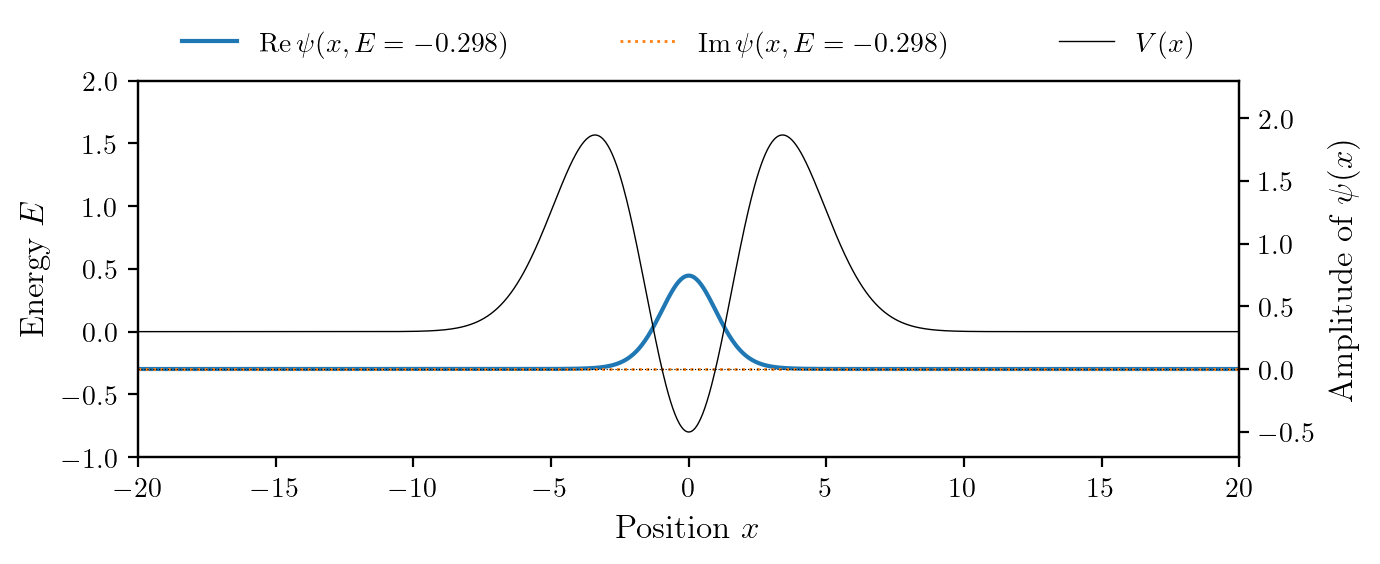

In [151]:
#%matplotlib widget
%matplotlib inline
xax = np.linspace(-20,20,1000)
forplot = np.zeros_like(xax, dtype=complex)

idx = np.arange(1, eig_vect.size+1, 1, dtype=int)

for i,x in enumerate(xax):
    v = basisf(x=x, nu=idx) * eig_vect
    forplot[i] = np.sum(v)

fig, ax = plt.subplots(num=None, figsize=(7,3), dpi=200, facecolor='w', edgecolor='k')
ax.plot(xax, np.real(forplot) - np.abs(eig_val),label=r"$\Re \psi(x,E = {:.3f})$".format(np.real(eig_val)))
ax.plot(xax, np.imag(forplot) - np.abs(eig_val),label=r"$\Im \psi(x,E = {:.3f})$".format(np.real(eig_val)), linestyle='dotted', linewidth=1)
ax.plot(xax, potential(xax), color='k', linewidth=0.5, label=r"$V(x)$")
ax.plot([-20,20],[np.real(eig_val)]*2,color='k', linewidth=0.4, linestyle='dotted')

plt.legend(loc='upper center', frameon=False, bbox_to_anchor=(0.5,1.2), ncol=3, columnspacing=4)

ax2 = ax.twinx()

ax.set_xlabel(r"$\textrm{Position }x$", fontsize=12)
ax.set_ylabel(r"$\textrm{Energy } E$", fontsize=12)
ax.set_xlim(-20,20)
ax.set_ylim(-1,2)

ax2.set_ylim(-1-np.real(eig_val), 2-np.real(eig_val))
ax2.set_ylabel(r"$\textrm{Amplitude of } \psi(x)$", fontsize=12)

plt.tight_layout()

plt.show()

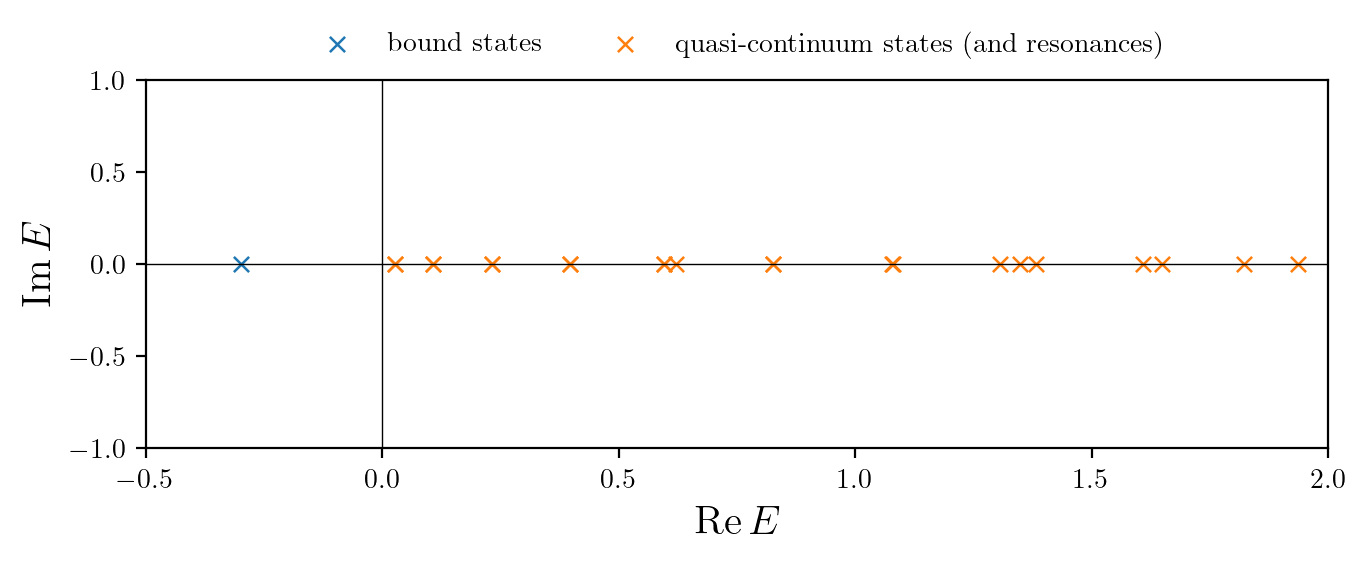

In [154]:
#%matplotlib widget
%matplotlib inline
fig, ax = plt.subplots(num=None, figsize=(7,3), dpi=200, facecolor='w', edgecolor='k')

eiv = np.sort(np.real(eig_vals))

plt.scatter(eiv[0], np.zeros_like(eiv[0]), marker='x',s=30, linewidth=0.9, label=r"$\textrm{bound states}$")
plt.scatter(eiv[1:], np.zeros_like(eiv[1:]), marker='x',s=30, linewidth=0.9, label=r"$\textrm{quasi-continuum states (and resonances)}$")
plt.xlim(-0.5, 2)
plt.ylim(-1,1)

plt.xlabel(r"$\Re E$", fontsize=15)
plt.ylabel(r"$\Im E$", fontsize=15)

plt.legend(loc='upper center', ncol=2, bbox_to_anchor=(0.5,1.2), frameon=False)
plt.tight_layout()

plt.plot([-10,10],[0,0], color='k', linewidth=0.5)
plt.plot([0,0],[-10,10], color='k', linewidth=0.5)

# Complex scaling

In [470]:
def Cint(func, a, b, **kwargs):
    def real_func(x):
        return np.real(func(x))
    def imag_func(x):
        return np.imag(func(x))
    real_integral = integrate.quad(real_func, a, b, **kwargs)
    imag_integral = integrate.quad(imag_func, a, b, **kwargs)
    return real_integral[0] + 1j*imag_integral[0]

def C_Vmel(x, nu1, nu2, theta, pars=parameters):
    #x = x * np.exp(1.0j * theta)
    a = basisf(x, nu1, pars=parameters)
    b = basisf(x, nu2, pars=parameters)
    V = potential(x * np.exp(1.0j * theta))
    
    return a*b*V

def C_Hmel(nu1, nu2, theta, pars=parameters):
    Lhalf = pars['x_max']
    d  = (xp.pi * nu2)/(2*Lhalf)
    V = Cint(partial(C_Vmel, nu1=nu1, nu2=nu2, theta=theta), -Lhalf, Lhalf, limit=300)
    out = pars['hbar'] / (2* pars['m']) * d**2 * overlapint(nu1, nu2) * np.exp(- 2.0j * theta) + V
    
    return out

def cline(x, theta):
    return x* np.exp(-2.0j * theta)

## CPU - single core

In [259]:
Nbas = 100
theta = 0.2
xp = np
C_results = xp.zeros((Nbas,Nbas),dtype=complex)

with xp.nditer(C_results, flags=['multi_index'], op_flags=['readwrite']) as it:
    for x in tqdm(it, total=Nbas**2):
        index = xp.array(it.multi_index) + 1
        x[...] = C_Hmel(*index, theta=theta)

C_eig_vals, C_eig_vects = np.linalg.eig(C_results)        

100%|███████████████████████████████████████████████████████████████████████████████| 10000/10000 [03:03<00:00, 54.57it/s]


## CPU - multi core

In [471]:
from joblib import Parallel, delayed
import math

In [472]:
def run_calc(i,j,theta):
    x = np.array([i, j, C_Hmel(i+1, j+1, theta)],dtype=complex)
    return x

In [473]:
%%time
Nbas = 300
theta = 0.2
xp = np

output_multi = Parallel(n_jobs=8)(delayed(run_calc)(i, j, theta) for i in range(Nbas) for j in range(Nbas))

C_results_multi = xp.zeros((Nbas,Nbas),dtype=complex)

for line in output_multi:
    i = int(np.real(line[0]))
    j = int(np.real(line[1]))
    val = line[2]
    C_results_multi[i,j] = val
        
C_eig_vals, C_eig_vects = np.linalg.eig(C_results_multi) 

CPU times: total: 3min 27s
Wall time: 15min 2s


## processing

In [50]:
# load saved data
loadp = "./complex_rez_2/theta_02/"
Cevals = np.load(loadp + "comp_evals_{}.npy".format(Nbas))
Cevects = np.load(loadp + "comp_evects_{}.npy".format(Nbas))

In [474]:
Cevals = np.sort(C_eig_vals)
Cevects = C_eig_vects.T[np.argsort(C_eig_vals)]

if True:
    Cdir = "./complex_rez_09-05-22/theta_02/"
    np.save(Cdir+"comp_evals_{}.npy".format(Nbas), Cevals)
    np.save(Cdir+"comp_evects_{}.npy".format(Nbas), Cevects)

C_eig_val = Cevals[0]
C_eig_vect = Cevects[0]

print(C_eig_val)

(-0.29795963785822316-7.962511987030784e-14j)


In [475]:
edge = 0.85

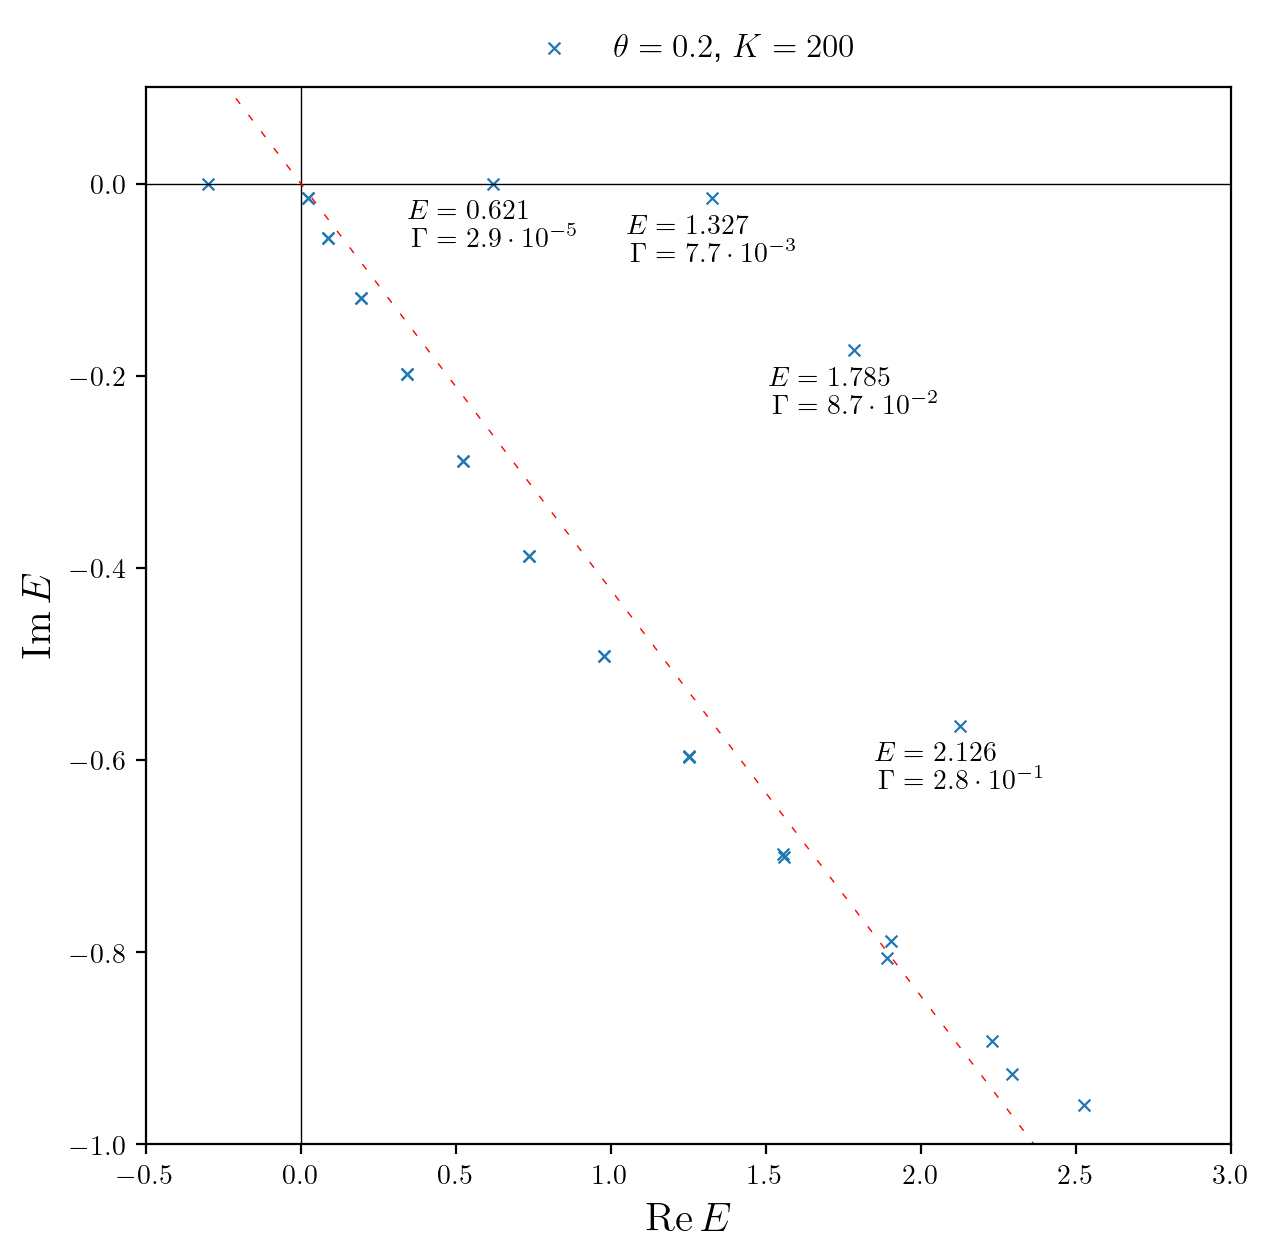

In [185]:
%matplotlib inline
#%matplotlib widget
fig, ax = plt.subplots(num=None, figsize=(7,7), dpi=200, facecolor='w', edgecolor='k')
plt.scatter(np.real(Cevals), np.imag(Cevals),s=18, marker='x',linewidth=0.8,label=r"$\theta = {:.1f}$, $K={:g}$".format(theta,Nbas))
plt.plot([-5,5],[0,0],color='k',linewidth=0.5)
plt.plot([0,0],[-5,5],color='k',linewidth=0.5)

xdat = cline(np.linspace(-1,4, 1000), theta)
plt.plot(np.real(xdat), np.imag(xdat), linestyle = (0,(5,10)), color= "r", linewidth=0.5)

#plt.plot(np.real(xdat), np.imag(xdat*edge), linestyle = (0,(5,10)), color= "r", linewidth=0.5,alpha=0.3)

resonances = [0,0]
for x,y in zip(np.real(Cevals),np.imag(Cevals)):
    if y > np.imag(cline(x, theta)*edge):
        #plt.annotate(r"\noindent\begin{{minipage}}{{4cm}} \centering $E = {:.3f} $\\$\Gamma = {:.3f} $ \end{{minipage}}".format(np.round(x,3), -y/2,3), (x, y-0.05), fontsize=9,ha='center')
        plt.annotate(r"\noindent\begin{{minipage}}{{4cm}}\setstretch{{0.4}}\begin{{align*}} E &= {:.3f} \\[-1.4mm] \Gamma &= {:.1e} \end{{align*}}\end{{minipage}}".format(np.round(x,3), num2tex(-y/2),3), 
                     (x, y-0.04), 
                     fontsize=5,ha='center')
        resonances = np.vstack([resonances,[x, y]])
        
plt.xlim(-0.5, 3)
plt.ylim(-1,0.1)
plt.xlabel(r"$\Re E$",fontsize=15)
plt.ylabel(r"$\Im E$",fontsize=15)
plt.legend(loc='upper center', bbox_to_anchor=(0.5,1.08),fontsize=12,frameon=False)
plt.show()

In [72]:
resonances

array([[ 0.00000000e+00,  0.00000000e+00],
       [ 6.20970948e-01, -5.82830268e-05],
       [ 1.32719698e+00, -1.54472841e-02],
       [ 1.78458582e+00, -1.73751640e-01],
       [ 2.12598371e+00, -5.64171075e-01]])

Peak displacement: -0.0001197


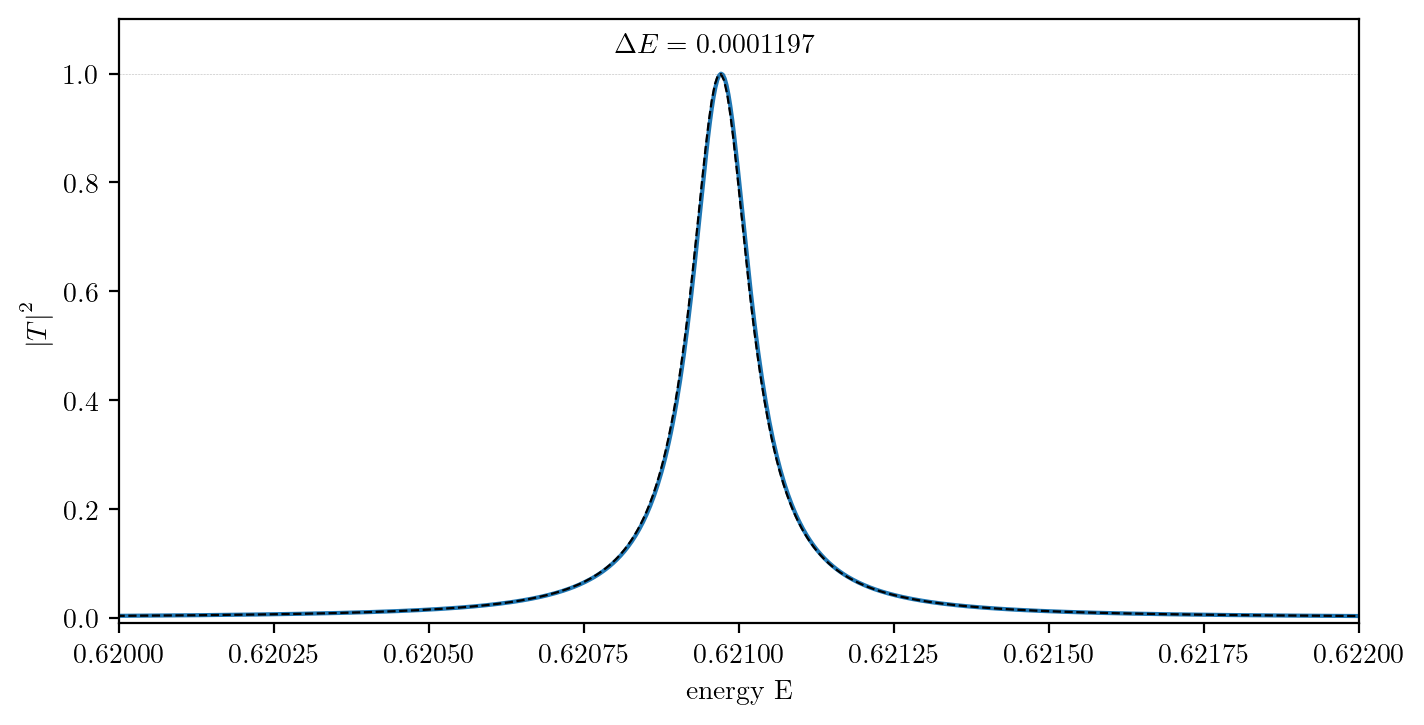

In [195]:
#%matplotlib widget
%matplotlib inline
fig, ax = plt.subplots(num=None, figsize=(8,4), dpi=200, facecolor='w', edgecolor='k')

def breit_wigner(E, reE, imE):
    gamma = - 2*imE 
    fr = gamma**2 / 4.0
    return fr / ((E - reE)**2 + fr)

xd = np.linspace(0,3,1000000)
maxs = list()

for x,y in resonances[1:2]:
    bwdata = breit_wigner(xd, x, y)
    plt.plot(xd, bwdata)
    
    mx = xd[np.where(bwdata == max(bwdata))]
    maxs.append(mx)

T = np.load("./Ndat_02/T.npy")
coord = np.load("./Ndat_02/energies.npy")
abT2 = np.abs(T)**2

if True:  #align first resonance peak
    dmax = coord[np.where(abT2 == max(abT2[np.where(coord <= 0.65)]))]
    delta =  maxs[0] - dmax
    coord = coord + delta
    print("Peak displacement: {:.7f}".format(float(delta)))

plt.plot(coord, abT2, color='k', linestyle='dashed', linewidth=0.8)
plt.plot([0,1],[1,1], color='grey',linewidth=0.2, linestyle='dotted')
    
plt.xlim(0.62,0.622)
#plt.xlim(0,3)
plt.ylim(-0.01,1.1)

plt.xlabel(r"$\textrm{energy E}$")
plt.ylabel(r"$\abs{T}^2$")
plt.annotate("$\Delta E = {:.7f}$".format(float(abs(delta))),xy=(0.6208,1.04))
plt.show()

1 (0.6209709482513475-5.8283026778378306e-05j)
2 (1.3271969754867947-0.01544728406577863j)


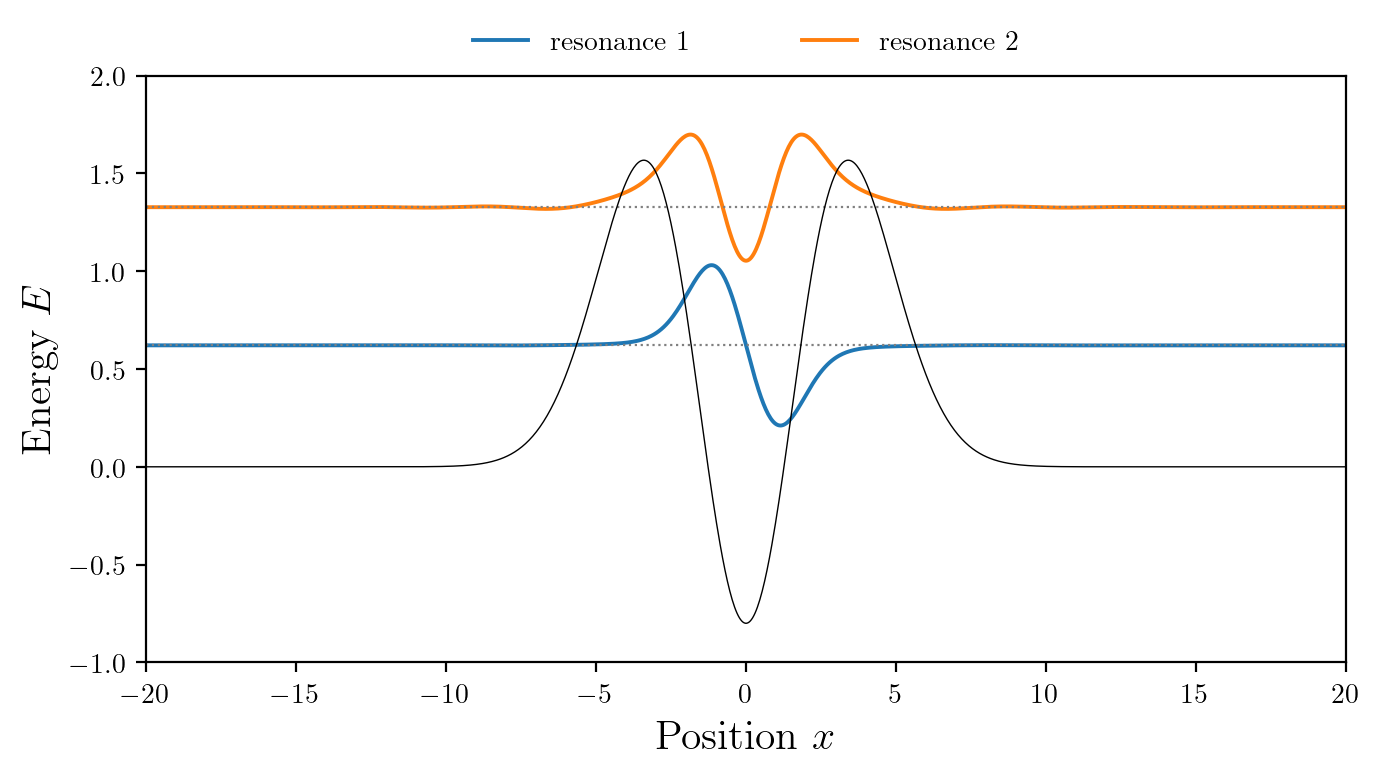

In [431]:
#%matplotlib widget
%matplotlib inline
xax = np.linspace(-20,20,1000)
forplot = np.zeros_like(xax, dtype=complex)

idx = np.arange(1, Cevects[0].size+1, 1, dtype=int)
    
theta = 0.2

fig, ax = plt.subplots(num=None, figsize=(7,4), dpi=200, facecolor='w', edgecolor='k')
count = 0

for i,ev in enumerate(Cevals):
    if np.imag(ev) > np.imag(cline(np.real(ev), theta)*edge):
        count += 1
        if count > 2:
            break
        print(count, ev)
        for k,coord in enumerate(xax):
            v = basisf(x=coord, nu=idx) * Cevects[i]
            isum = xp.sum(xp.imag(v))
            rsum = xp.sum(xp.real(v))
            forplot[k] = rsum + 1.0j*isum
        plt.plot(xax, (np.real(forplot))*0.7 +np.real(Cevals[i]), linewidth=1.4,label=r"\textrm{resonance }"+r"${:g}$".format(count))
        plt.plot([-20,20],[np.real(Cevals[i])]*2, linestyle='dotted', linewidth=0.8, color='grey')
    
plt.plot(xax, potential(xax), color='k', linewidth=0.5)
#plt.plot([-20,20],[C_eig_val]*2,color='k', linewidth=0.4, linestyle='dotted')
plt.xlim(-20,20)
plt.ylim(-1,2)
plt.xlabel(r"$\textrm{Position } x$",fontsize=15)
plt.ylabel(r"$\textrm{Energy } E$",fontsize=15)
plt.legend(frameon=False,ncol=2,loc='upper center',bbox_to_anchor=(0.5,1.12),columnspacing=4)
plt.show()

In [439]:
hamy1 = np.load("C:/Users/micha/Downloads/rez_y_0.62109.npy")
hamx1 = np.load("C:/Users/micha/Downloads/rez_x_0.62109.npy")
hamy2 = np.load("C:/Users/micha/Downloads/rez_y_1.32896.npy")
hamx2 = np.load("C:/Users/micha/Downloads/rez_x_1.32896.npy")

e1=0.6210903346505577
e2=1.3289629179381965

1 (0.6209709482513479-5.828302675167492e-05j)
2 (1.327196975486878-0.015447284065747649j)


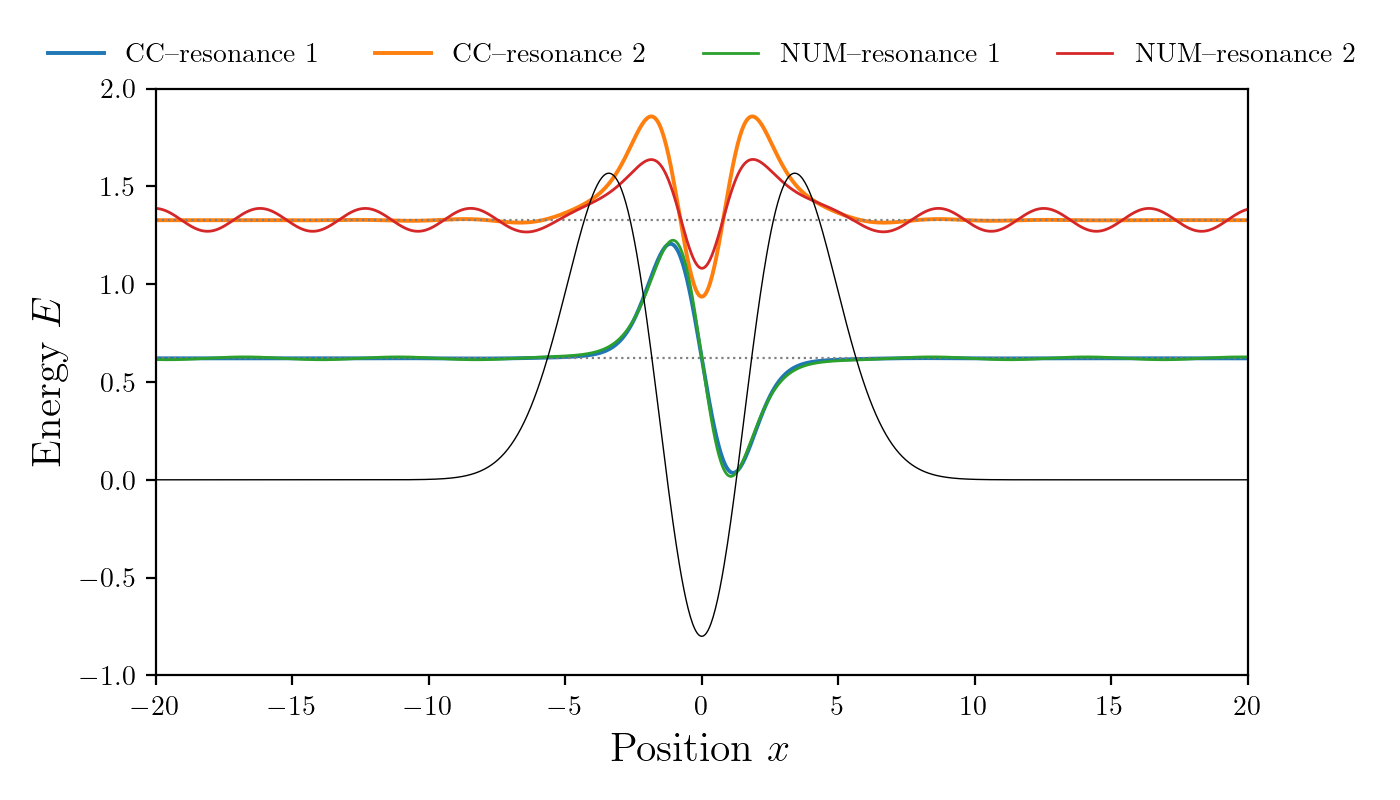

In [478]:
%matplotlib widget
#%matplotlib inline
xax = np.linspace(-20,20,1000)
forplot = np.zeros_like(xax, dtype=complex)

idx = np.arange(1, Cevects[0].size+1, 1, dtype=int)
    
theta = 0.2

fig, ax = plt.subplots(num=None, figsize=(7,4), dpi=200, facecolor='w', edgecolor='k')
count = 0

for i,ev in enumerate(Cevals):
    if np.imag(ev) > np.imag(cline(np.real(ev), theta)*edge):
        count += 1
        if count > 2:
            break
        print(count, ev)
        for k,coord in enumerate(xax):
            v = basisf(x=coord, nu=idx) * Cevects[i] #*np.exp(-theta * 1j /2)
            isum = xp.sum(xp.imag(v))
            rsum = xp.sum(xp.real(v))
            forplot[k] = rsum + 1.0j*isum
        plt.plot(xax, (np.real(forplot)) +np.real(ev), linewidth=1.4,label=r"\textrm{CC--resonance }"+r"${:g}$".format(count))
        plt.plot([-20,20],[np.real(ev)]*2, linestyle='dotted', linewidth=0.8, color='grey')
        
##
plt.plot(hamx1, -np.real(hamy1)*1.6*np.sqrt(1 / (2*np.pi * np.sqrt(2 * e1))) + e1, label=r"$\textrm{NUM--resonance 1}$", linewidth=1)
#plt.plot(hamx1, np.imag(hamy1)*np.sqrt(1 / (2*np.pi * np.sqrt(2 * e1))) + e1, label="$\textrm{rez1r}$", linewidth=1, linestyle='dashed')
plt.plot(hamx1, np.real(-1j*hamy2)*np.sqrt(1 / (2*np.pi * np.sqrt(2 * e2))) + e2, label=r"$\textrm{NUM--resonance 2}$", linewidth=1)
##
    
plt.plot(xax, potential(xax), color='k', linewidth=0.5)
#plt.plot([-20,20],[C_eig_val]*2,color='k', linewidth=0.4, linestyle='dotted')
plt.xlim(-20,20)
plt.ylim(-1,2)
plt.xlabel(r"$\textrm{Position } x$",fontsize=15)
plt.ylabel(r"$\textrm{Energy } E$",fontsize=15)
plt.legend(frameon=False,ncol=4,loc='upper center',bbox_to_anchor=(0.5,1.12),columnspacing=2)
plt.show()

## from metacentrum

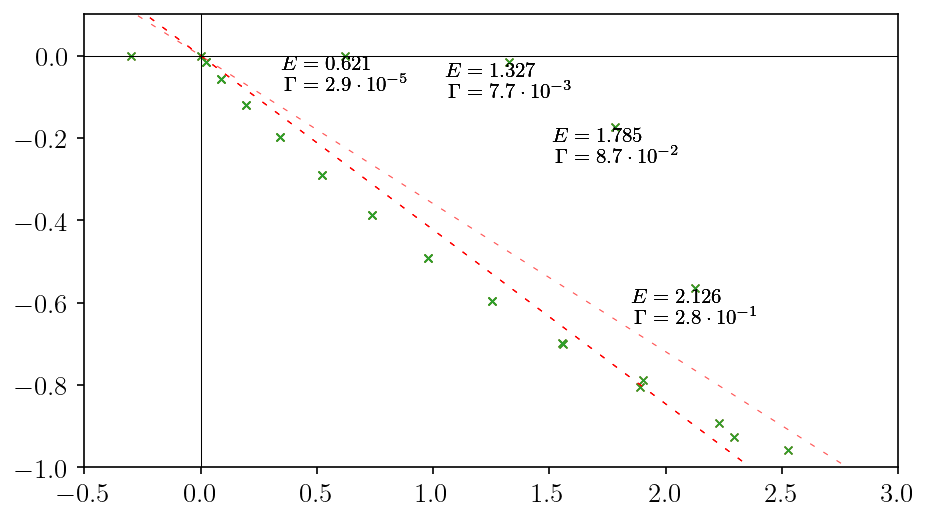

In [11]:
mpath = "./from_meta/"
labs = [100,500,1000]
edge = 0.85

fig, ax = plt.subplots(num=None, figsize=(7,4), dpi=150, facecolor='w', edgecolor='k')

for m in labs:
    Cevals = np.load(mpath+"{}_02/".format(m)+"Cevals_{}_0.2.npy".format(m))
    Cevects = np.load(mpath+"{}_02/".format(m)+"Cevects_{}_0.2.npy".format(m))
    
    plt.scatter(np.real(Cevals), np.imag(Cevals),s=14, marker='x',linewidth=0.8)


    xdat = cline(np.linspace(-1,4, 1000), 0.2)
    plt.plot(np.real(xdat), np.imag(xdat), linestyle = (0,(5,10)), color= "r", linewidth=0.5)

    plt.plot(np.real(xdat), np.imag(xdat*edge), linestyle = (0,(5,10)), color= "r", linewidth=0.5,alpha=0.3)

    resonances = [0,0]
    for x,y in zip(np.real(Cevals),np.imag(Cevals)):
        if y > np.imag(cline(x, 0.2)*edge):
            #plt.annotate(r"\noindent\begin{{minipage}}{{4cm}} \centering $E = {:.3f} $\\$\Gamma = {:.3f} $ \end{{minipage}}".format(np.round(x,3), -y/2,3), (x, y-0.05), fontsize=9,ha='center')
            plt.annotate(r"\noindent\begin{{minipage}}{{4cm}}\setstretch{{0.4}}\begin{{align*}} E &= {:.3f} \\[-1.4mm] \Gamma &= {:.1e} \end{{align*}}\end{{minipage}}".format(np.round(x,3), num2tex(-y/2),3), 
                         (x, y-0.04), 
                         fontsize=5,ha='center')
            resonances = np.vstack([resonances,[x, y]])
            
plt.plot([-5,5],[0,0],color='k',linewidth=0.5)
plt.plot([0,0],[-5,5],color='k',linewidth=0.5)
plt.xlim(-0.5, 3)
plt.ylim(-1,0.1)
plt.show()

TypeError: unsupported format string passed to numpy.ndarray.__format__

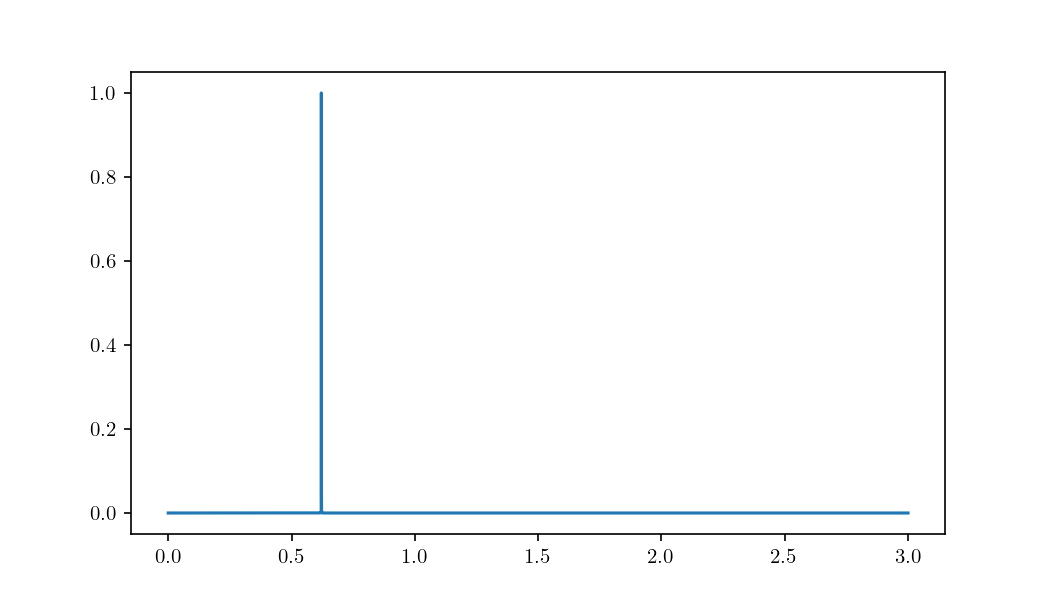

In [31]:
mpath = "./from_meta/"
labs = [100,500,1000]
edge = 0.85

def breit_wigner(E, reE, imE):
    gamma = - 2*imE 
    fr = gamma**2 / 4.0
    return fr / ((E - reE)**2 + fr)

fig, ax = plt.subplots(num=None, figsize=(7,4), dpi=150, facecolor='w', edgecolor='k')

for m in labs:
    Cevals = np.load(mpath+"{}_02/".format(m)+"Cevals_{}_0.2.npy".format(m))
    Cevects = np.load(mpath+"{}_02/".format(m)+"Cevects_{}_0.2.npy".format(m))

    resonances = [0,0]
    for x,y in zip(np.real(Cevals),np.imag(Cevals)):
        if y > np.imag(cline(x, 0.2)*edge):
            resonances = np.vstack([resonances,[x, y]])
            
    xd = np.linspace(0,3,1000000)
    for x,y in resonances[1:2]:
        plt.plot(xd, breit_wigner(xd, x, y), label=str(m))
        
        print("{:.0f}:  {:+.5f}".format(m,np.real(resonances[1])))
    

T = np.load("./Ndat_02/T.npy")
coord = np.load("./Ndat_02/energies.npy")
plt.plot(coord, np.abs(T)**2, color='k', linestyle='dashed', linewidth=0.8)
plt.legend()
plt.xlim(0.62,0.622)
#plt.xlim(0,3)
plt.ylim(-0.01,1.1)
plt.show()
   

# Interaction with laser

## Floquet theory

In [219]:
from joblib import Parallel, delayed
import math

njobs = 8

In [220]:
Nbas = 200
Nnus = 6
omega = 1
alpha = 0

nus = [-Nnus, Nnus]
xp = np

In [221]:
def potential(x):
    x2 = x**2
    V = (x2 / 2.0 - 0.8) * xp.exp(-0.1 * x2)
    return V

def potential_prime(x):
    x2 = x**2
    Vprime = (1.16 * x - 0.1 * x2 * x) * xp.exp(-0.1 * x2)
    return Vprime

In [222]:
# from bound state calculation

def basisf(x, nu, pars=parameters):
    Lhalf = pars['x_max']
    Lhalfinv = 1.0 / Lhalf
    out = xp.sqrt(Lhalfinv) * xp.sin( Lhalfinv * xp.pi / 2 * nu * (x + Lhalf) )
    
    return out
    
def overlapint(nu1,nu2):
    return int(nu1 == nu2)
    
def Vmel(x, nu1, nu2, pars=parameters):
    a = basisf(x, nu1, pars=parameters)
    b = basisf(x, nu2, pars=parameters)
    V = potential(x)
    
    return a*b*V

def Hmel(nu1, nu2, pars=parameters):
    Lhalf = pars['x_max']
    d  = (xp.pi * nu2)/(2*Lhalf)
    V = integrate.quad(partial(Vmel, nu1=nu1, nu2=nu2), -Lhalf, Lhalf, limit=200)[0]
    out = pars['hbar'] / (2* pars['m']) * d**2 * overlapint(nu1, nu2) + V
    
    return out

def dVmel(i, j, pars=parameters):
    Lhalf = pars['x_max']
    dV = integrate.quad(lambda x: basisf(x, i) * basisf(x, j) * potential_prime(x), -Lhalf, Lhalf, limit=200)[0]
    return dV

In [223]:
%%time

# BOUND STATES calculator !!!!!!!

def run_BS(i,j):
    x = np.array([i, j, Hmel(i+1,j+1)],dtype=complex)
    return x

BS_output = Parallel(n_jobs=njobs)(delayed(run_BS)(i, j) for i in range(Nbas) for j in range(Nbas))
BS_results = xp.zeros((Nbas,Nbas),dtype=complex)

for line in BS_output:
    i = int(np.real(line[0]))
    j = int(np.real(line[1]))
    val = line[2]
    BS_results[i,j] = val
        
# BS_eig_vals, BS_eig_vects = np.linalg.eig(BS_results) 
# BS_eig_vects = BS_eig_vects.T[np.argsort(BS_eig_vals)]
# BS_eig_vals = np.sort(BS_eig_vals)
# print("E of bound state: ", BS_eig_vals[0])

KeyboardInterrupt: 

In [224]:
%%time

# Vprime matrix part - in bound state solution basis - FAST implementation

def run_dV(i, j):
    out = np.array([i, j, dVmel(i+1, j+1)],dtype=complex)
    return out

dV_output = Parallel(n_jobs=njobs)(delayed(run_dV)(i,j) for i in range(Nbas) for j in range(Nbas))
dV_results = xp.zeros((Nbas,Nbas),dtype=complex)

for line in dV_output:
    i = int(np.real(line[0]))
    j = int(np.real(line[1]))
    val = line[2]
    dV_results[i,j] = val

KeyboardInterrupt: 

In [225]:
nu_range = np.arange(*nus + np.array([0,1]))
Hp_diag_shift = np.identity(nu_range.size) * nu_range
Hp_diag = np.identity(nu_range.size)
Hp_offdiag = (np.eye(nu_range.size,k=1) + np.eye(nu_range.size, k=-1))

Hp_total = np.kron(Hp_diag, BS_results) + np.kron(Hp_diag_shift, np.identity(Nbas) * omega) + np.kron(Hp_offdiag, dV_results) * alpha / 2.0
Hp_total.shape

(2600, 2600)

In [128]:
FQ_eig_vals, FQ_eig_vects = np.linalg.eig(Hp_total) 
#FQ_eig_vals.reshape([7,100])

In [134]:
%matplotlib inline

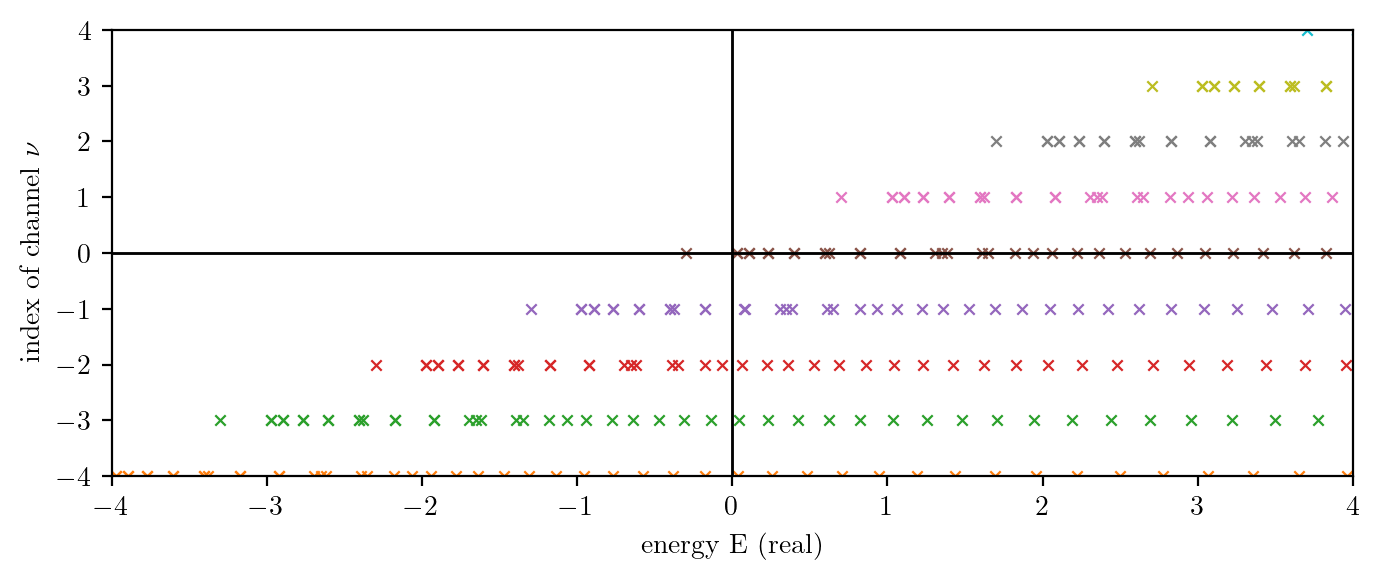

In [135]:
fig, ax = plt.subplots(num=None, figsize=(7,3), dpi=200, facecolor='w', edgecolor='k')

for i,line in enumerate(FQ_eig_vals.reshape([nu_range.size,Nbas])):
    plt.scatter(np.real(line), np.zeros_like(line) + (i-Nnus)* 1, s=14, marker='x',linewidth=0.8)
    plt.plot([-5,5],[0,0],color='k',linewidth=0.5)
    plt.plot([0,0],[-5,5],color='k',linewidth=0.5)
     
plt.xlim(-4, 4)
plt.ylim(-4,4)

plt.ylabel(r"$\textrm{index of channel } \nu$")
plt.xlabel(r"$\textrm{energy E (real)}$")
plt.tight_layout()

plt.show()

# Nonhermitian Floquet theory

In [405]:
from joblib import Parallel, delayed
import math
import matplotlib.cm as cm
import matplotlib.colors as colors

njobs = 8

In [409]:
Nbas = 80
Nnus = 6
omega = 1
alpha = 0

F_theta = 0.2

nus = [-Nnus, Nnus]
xp = np

In [410]:
def potential(x):
    x2 = x**2
    V = (x2 / 2.0 - 0.8) * xp.exp(-0.1 * x2)
    return V

def potential_prime(x):
    x2 = x**2
    Vprime = (1.16 * x - 0.1 * x2 * x) * xp.exp(-0.1 * x2)
    return Vprime

In [411]:
# def basisf(x, nu, pars=parameters):
#     Lhalf = pars['x_max']
#     Lhalfinv = 1.0 / Lhalf
#     out = xp.sqrt(Lhalfinv) * xp.sin( Lhalfinv * xp.pi / 2 * nu * (x + Lhalf) )
    
#     return out
    
# def overlapint(nu1,nu2):
#     return int(nu1 == nu2)

def Cint(func, a, b, **kwargs):
    real_integral = integrate.quad(lambda x: np.real(func(x)), a, b, **kwargs)[0]
    imag_integral = integrate.quad(lambda x: np.imag(func(x)), a, b, **kwargs)[0]
    return real_integral + 1.0j * imag_integral

def C_Vmel(x, nu1, nu2, theta, pars=parameters):
    a = basisf(x, nu1, pars=parameters)
    b = basisf(x, nu2, pars=parameters)
    V = potential(x * np.exp(1.0j * theta))
    
    return a*b*V

def C_Hmel(nu1, nu2, theta, pars=parameters):
    Lhalf = pars['x_max']
    d  = (xp.pi * nu2)/(2*Lhalf)
    V = Cint(partial(C_Vmel, nu1=nu1, nu2=nu2, theta=theta), -Lhalf, Lhalf, limit=300)
    out = pars['hbar'] / (2* pars['m']) * d**2 * overlapint(nu1, nu2) * np.exp(- 2.0j * theta) + V
    
    return out

def cline(x, theta):
    return x* np.exp(-2.0j * theta)

def NHF_dVmel(i, j, theta, pars=parameters):
    Lhalf = pars['x_max']
    func = lambda x: basisf(x, i) * basisf(x, j) * potential_prime(x * np.exp(1.0j * theta))
    
    dV_real = integrate.quad(lambda x: np.real(func(x)), -Lhalf, Lhalf, limit=200)[0]
    dV_imag = integrate.quad(lambda x: np.imag(func(x)), -Lhalf, Lhalf, limit=200)[0]
    
    return dV_real + 1.0j * dV_imag

In [412]:
%%time

# complex scaling - non-interacting system !!!!

def CNI_run(i, j, theta):
    x = np.array([i, j, C_Hmel(i+1, j+1, theta)], dtype=complex)
    return x

CNI_output = Parallel(n_jobs=njobs)(delayed(CNI_run)(i, j, F_theta) for i in range(Nbas) for j in range(Nbas))
CNI_results = xp.zeros((Nbas, Nbas), dtype=complex)

for line in CNI_output:
    i = int(np.real(line[0]))
    j = int(np.real(line[1]))
    val = line[2]
    CNI_results[i,j] = val
        
# CNI_eig_vals, CNI_eig_vects = np.linalg.eig(CNI_results) 

CPU times: total: 6.28 s
Wall time: 35.5 s


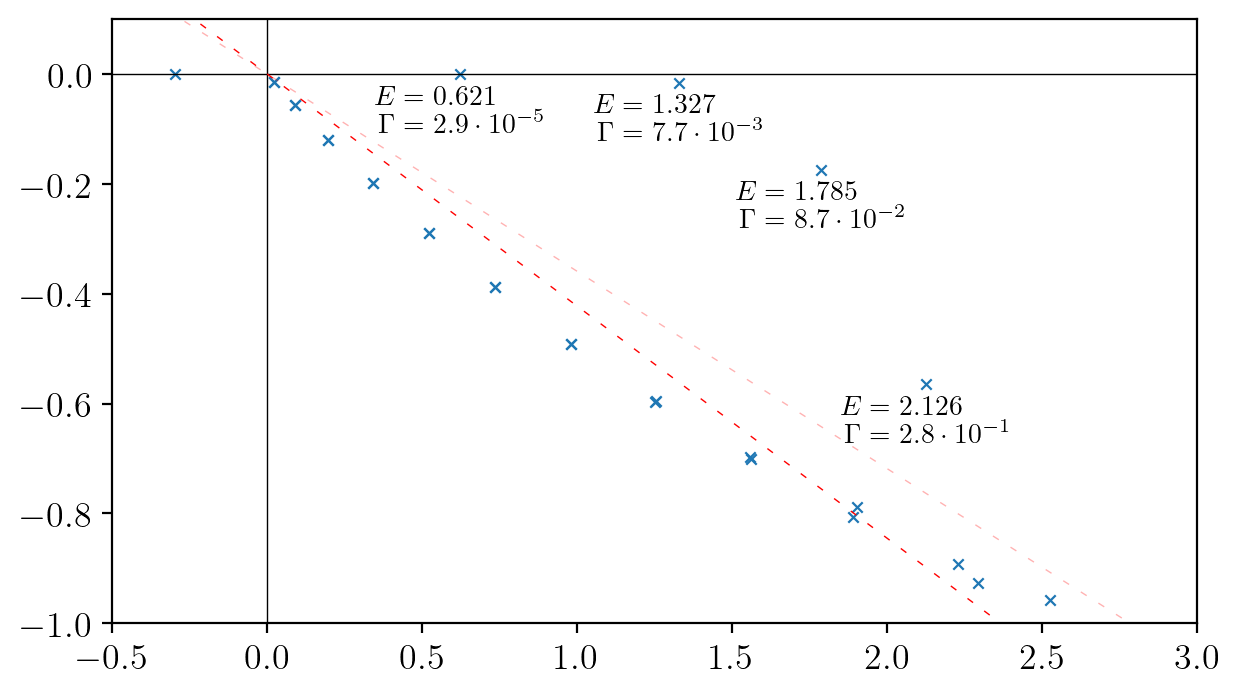

In [425]:
fig, ax = plt.subplots(num=None, figsize=(7,4), dpi=200, facecolor='w', edgecolor='k')
plt.scatter(np.real(CNI_eig_vals), np.imag(CNI_eig_vals),s=14, marker='x',linewidth=0.8)
plt.plot([-5,5],[0,0],color='k',linewidth=0.5)
plt.plot([0,0],[-5,5],color='k',linewidth=0.5)

xdat = cline(np.linspace(-1,4, 1000), 0.2)
plt.plot(np.real(xdat), np.imag(xdat), linestyle = (0,(5,10)), color= "r", linewidth=0.5)

plt.plot(np.real(xdat), np.imag(xdat * edge), linestyle = (0,(5,10)), color= "r", linewidth=0.5, alpha=0.3)

CNIevals = np.sort(CNI_eig_vals)
CNIevects = CNI_eig_vects.T[np.argsort(CNI_eig_vals)]

edge = 0.85
resonances = [0,0]
for x,y in zip(np.real(CNIevals),np.imag(CNIevals)):
    if y > np.imag(cline(x, 0.2)*edge):
        #plt.annotate(r"\noindent\begin{{minipage}}{{4cm}} \centering $E = {:.3f} $\\$\Gamma = {:.3f} $ \end{{minipage}}".format(np.round(x,3), -y/2,3), (x, y-0.05), fontsize=9,ha='center')
        plt.annotate(r"\noindent\begin{{minipage}}{{4cm}}\setstretch{{0.4}}\begin{{align*}} E &= {:.3f} \\[-1.4mm] \Gamma &= {:.1e} \end{{align*}}\end{{minipage}}".format(np.round(x,3), num2tex(-y/2),3), 
                     (x, y-0.06), 
                     fontsize=5,ha='center')
        resonances = np.vstack([resonances,[x, y]])
        
plt.xlim(-0.5, 3)
plt.ylim(-1,0.1)
plt.show()

In [414]:
%%time

# Vprime matrix part - in bound state complex scaled solution basis - FAST implementation

def NHF_run(i, j, theta):
    out = np.array([i, j, NHF_dVmel(i+1, j+1, theta)], dtype=complex)
    return out

NHF_output = Parallel(n_jobs=njobs)(delayed(NHF_run)(i,j, F_theta) for i in range(Nbas) for j in range(Nbas))
NHF_results = xp.zeros((Nbas,Nbas), dtype=complex)

for line in NHF_output:
    i = int(np.real(line[0]))
    j = int(np.real(line[1]))
    val = line[2]
    NHF_results[i,j] = val

CPU times: total: 4.89 s
Wall time: 27.9 s


In [240]:
alpha = 0.0001

In [415]:
### matrix manipulation start HERE !!!

nu_range = np.arange(*nus + np.array([0,1]))

Hp_diag_shift = np.identity(nu_range.size) * nu_range
Hp_diag = np.identity(nu_range.size)
Hp_offdiag = (np.eye(nu_range.size,k=1) + np.eye(nu_range.size, k=-1))

NHF_Hp_total = np.kron(Hp_diag, CNI_results) + np.kron(Hp_diag_shift, np.identity(Nbas) * omega) + np.kron(Hp_offdiag, NHF_results) * alpha / 2.0
NHF_Hp_total.shape

(1040, 1040)

In [416]:
NHF_eig_vals, NHF_eig_vects = np.linalg.eig(NHF_Hp_total) 
#FQ_eig_vals.reshape([7,100])

In [417]:
%%time
######
#### calculation of a single NONINTERACTING
######

def Cint(func, a, b, **kwargs):
    def real_func(x):
        return np.real(func(x))
    def imag_func(x):
        return np.imag(func(x))
    real_integral = integrate.quad(real_func, a, b, **kwargs)
    imag_integral = integrate.quad(imag_func, a, b, **kwargs)
    return real_integral[0] + 1j*imag_integral[0]

def C_Vmel(x, nu1, nu2, theta, pars=parameters):
    #x = x * np.exp(1.0j * theta)
    a = basisf(x, nu1, pars=parameters)
    b = basisf(x, nu2, pars=parameters)
    V = potential(x * np.exp(1.0j * theta))
    
    return a*b*V

def C_Hmel(nu1, nu2, theta, pars=parameters):
    Lhalf = pars['x_max']
    d  = (xp.pi * nu2)/(2*Lhalf)
    V = Cint(partial(C_Vmel, nu1=nu1, nu2=nu2, theta=theta), -Lhalf, Lhalf, limit=300)
    out = pars['hbar'] / (2* pars['m']) * d**2 * overlapint(nu1, nu2) * np.exp(- 2.0j * theta) + V
    
    return out

def cline(x, theta):
    return x* np.exp(-2.0j * theta)

def run_calc(i,j,theta):
    x = np.array([i, j, C_Hmel(i+1, j+1, theta)],dtype=complex)
    return x

output_multi = Parallel(n_jobs=8)(delayed(run_calc)(i, j, F_theta) for i in range(Nbas) for j in range(Nbas))
C_results_multi = xp.zeros((Nbas,Nbas),dtype=complex)

for line in output_multi:
    i = int(np.real(line[0]))
    j = int(np.real(line[1]))
    val = line[2]
    C_results_multi[i,j] = val
        
CeN, CevN = np.linalg.eig(C_results_multi)
CeNI = np.sort(CeN)
CevNI = CevN.T[np.argsort(CeN)]

CPU times: total: 5.33 s
Wall time: 24.2 s


100%|███████████████████████████████████████████████████████████████████████████████████| 400/400 [20:05<00:00,  3.01s/it]


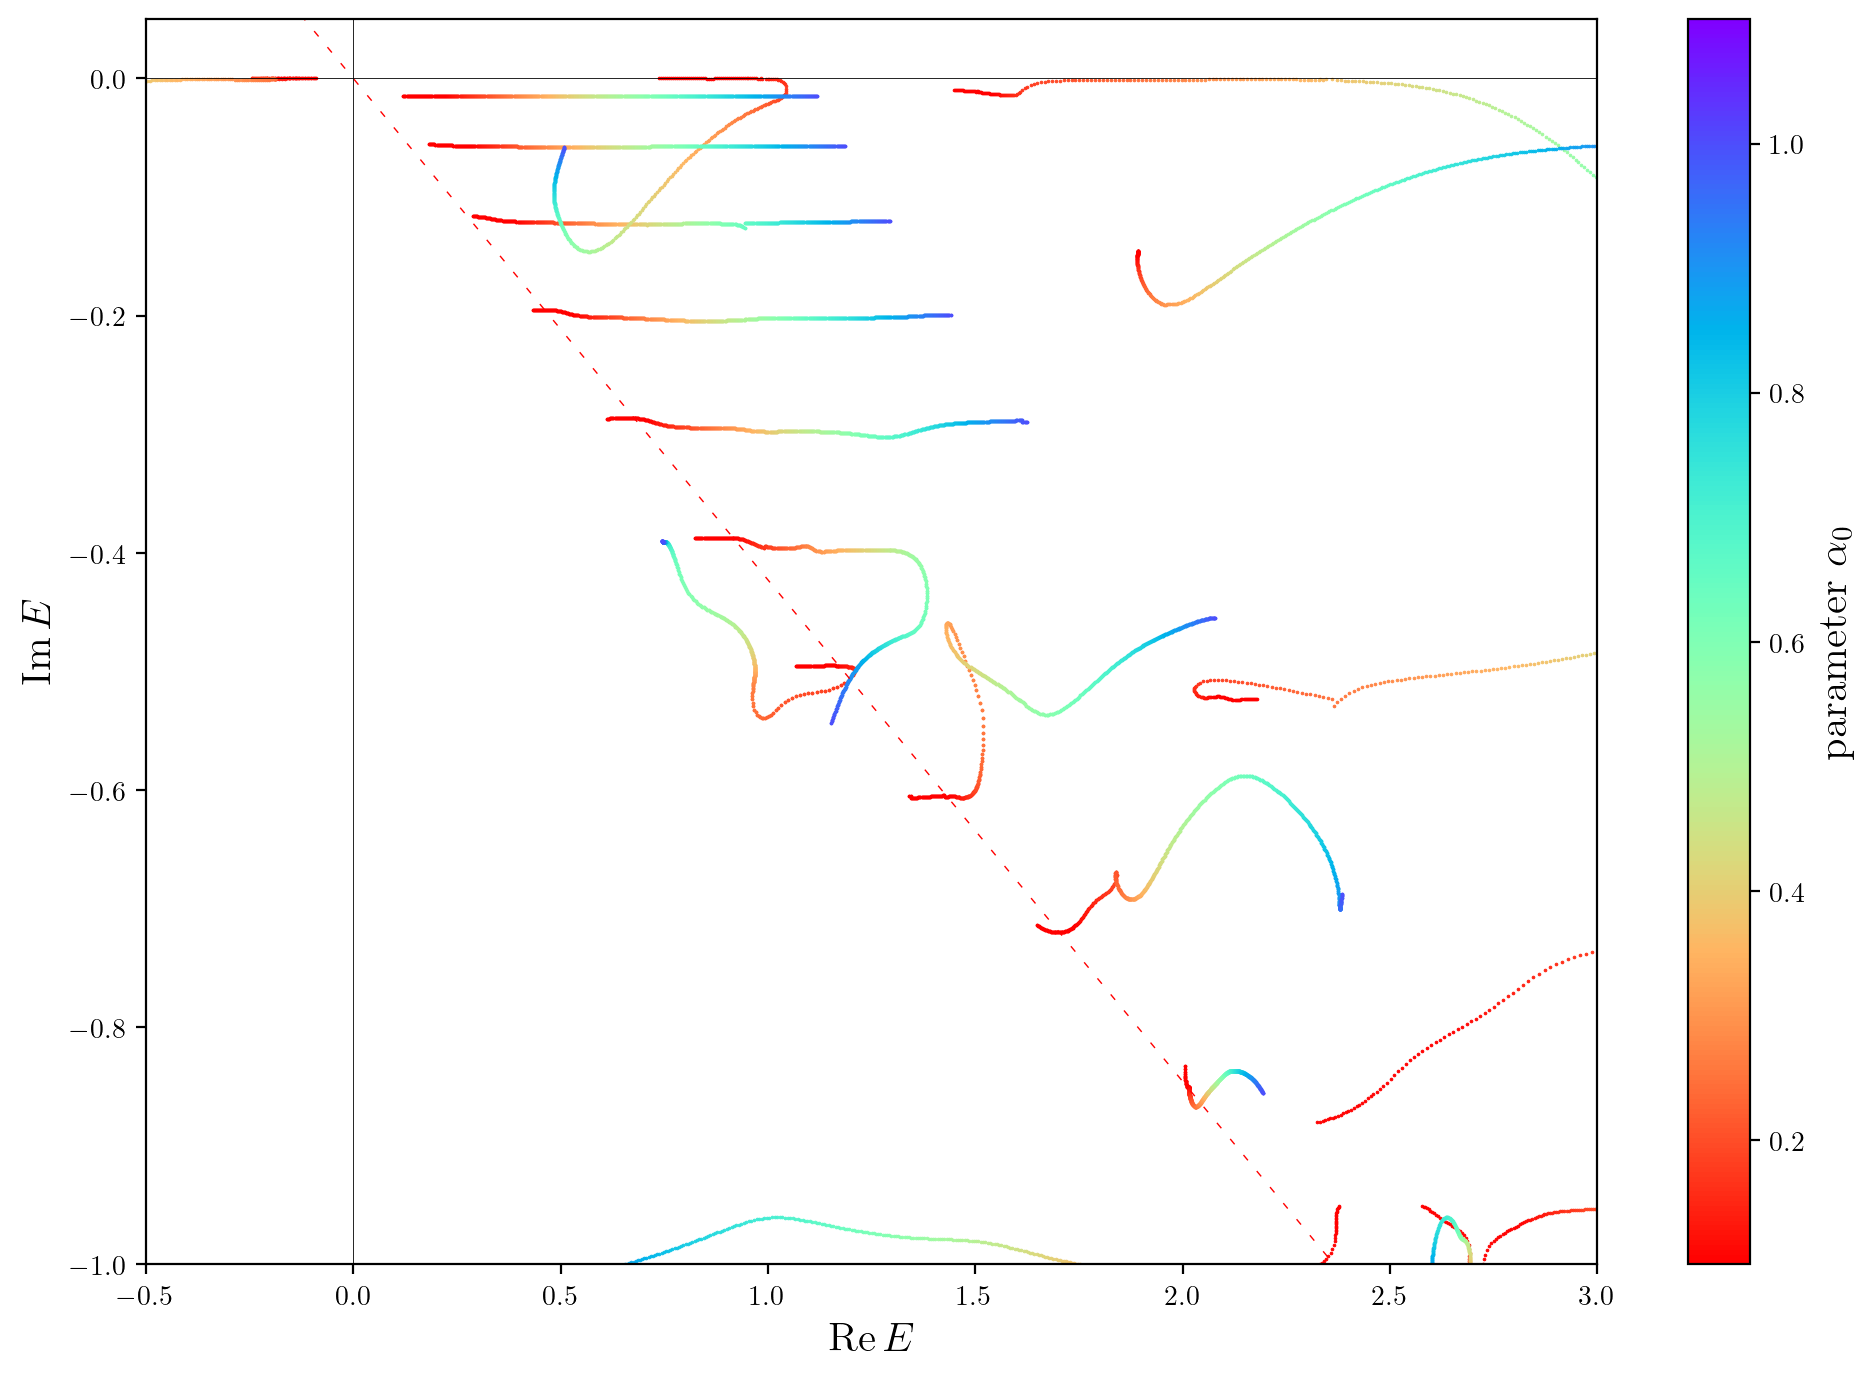

In [430]:
%matplotlib inline
#%matplotlib widget
from matplotlib import cm
import matplotlib.cm as cmx
import matplotlib.colors as colors

fig, ax = plt.subplots(num=None, figsize=(10,7), dpi=200, facecolor='w', edgecolor='k')

nsteps = 400
stepsize = 0.0025

cmap = plt.get_cmap('rainbow_r')
cNorm  = colors.Normalize(vmin=0.1, vmax=0.1+nsteps*stepsize)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cmap)


nu_range = np.arange(*nus + np.array([0,1]))

Hp_diag_shift = np.identity(nu_range.size) * nu_range
Hp_diag = np.identity(nu_range.size)
Hp_offdiag = (np.eye(nu_range.size,k=1) + np.eye(nu_range.size, k=-1))

xdat = cline(np.linspace(-1,4, 1000), F_theta)
plt.plot(np.real(xdat), np.imag(xdat), linestyle = (0,(5,10)), color= "r", linewidth=0.5)

pre_NHF = np.kron(Hp_offdiag, NHF_results) * alpha / 2.0

reference = CeNI + 0.1
alpha = 1

for n in tqdm(range(nsteps)):
    omega= 0.1 + n * stepsize 
    NHF_Hp_total =  pre_NHF + np.kron(Hp_diag, CNI_results) + np.kron(Hp_diag_shift, np.identity(Nbas) * omega)
    NHF_eig_vals, NHF_eig_vects = np.linalg.eig(NHF_Hp_total) 

    #data = NHF_eig_vals.reshape([nu_range.size,Nbas])
    
    data = list()
    for idx,i in enumerate(reference):
        df = np.abs(NHF_eig_vals - i)
        mindf = np.argmin(df)
        data.append([idx, NHF_eig_vals[mindf]])
    data = np.array(data).T
    
    #plt.scatter(np.real(data[Nnus+1]), np.imag(data[Nnus+1]), s=1, marker='o',linewidth=0.3, color=scalarMap.to_rgba(n))
    plt.scatter(np.real(data[1]), np.imag(data[1]), s=1, marker='o',linewidth=0.3, color=scalarMap.to_rgba(n*stepsize))
    reference = data[1]

#plt.scatter(np.real(CeNI), np.imag(CeNI), s=4, marker='x',linewidth=0.4, color="red")

plt.plot([-15,15],[0,0],color='k',linewidth=0.3)
plt.plot([0,0],[-15,15],color='k',linewidth=0.3)
     
plt.xlim(-0.5, 3)
plt.ylim(-1,0.05)
plt.xlabel(r"$\Re E$",fontsize=15)
plt.ylabel(r"$\Im E$",fontsize=15)

cb = fig.colorbar(cm.ScalarMappable(norm=cNorm, cmap=cmap), ax=ax)
cb.set_label(label=r"$\textrm{parameter } \alpha_0$", fontsize=15)
#plt.clim([0, nsteps*stepsize])
plt.savefig("C:/Users/micha/Desktop/imgXY.png")
plt.show()

In [428]:
plt.savefig("C:/Users/micha/Desktop/imgXY.png")

<Figure size 432x288 with 0 Axes>

100%|█████████████████████████████████████████████████████████████████████████████████| 500/500 [8:16:06<00:00, 59.53s/it]


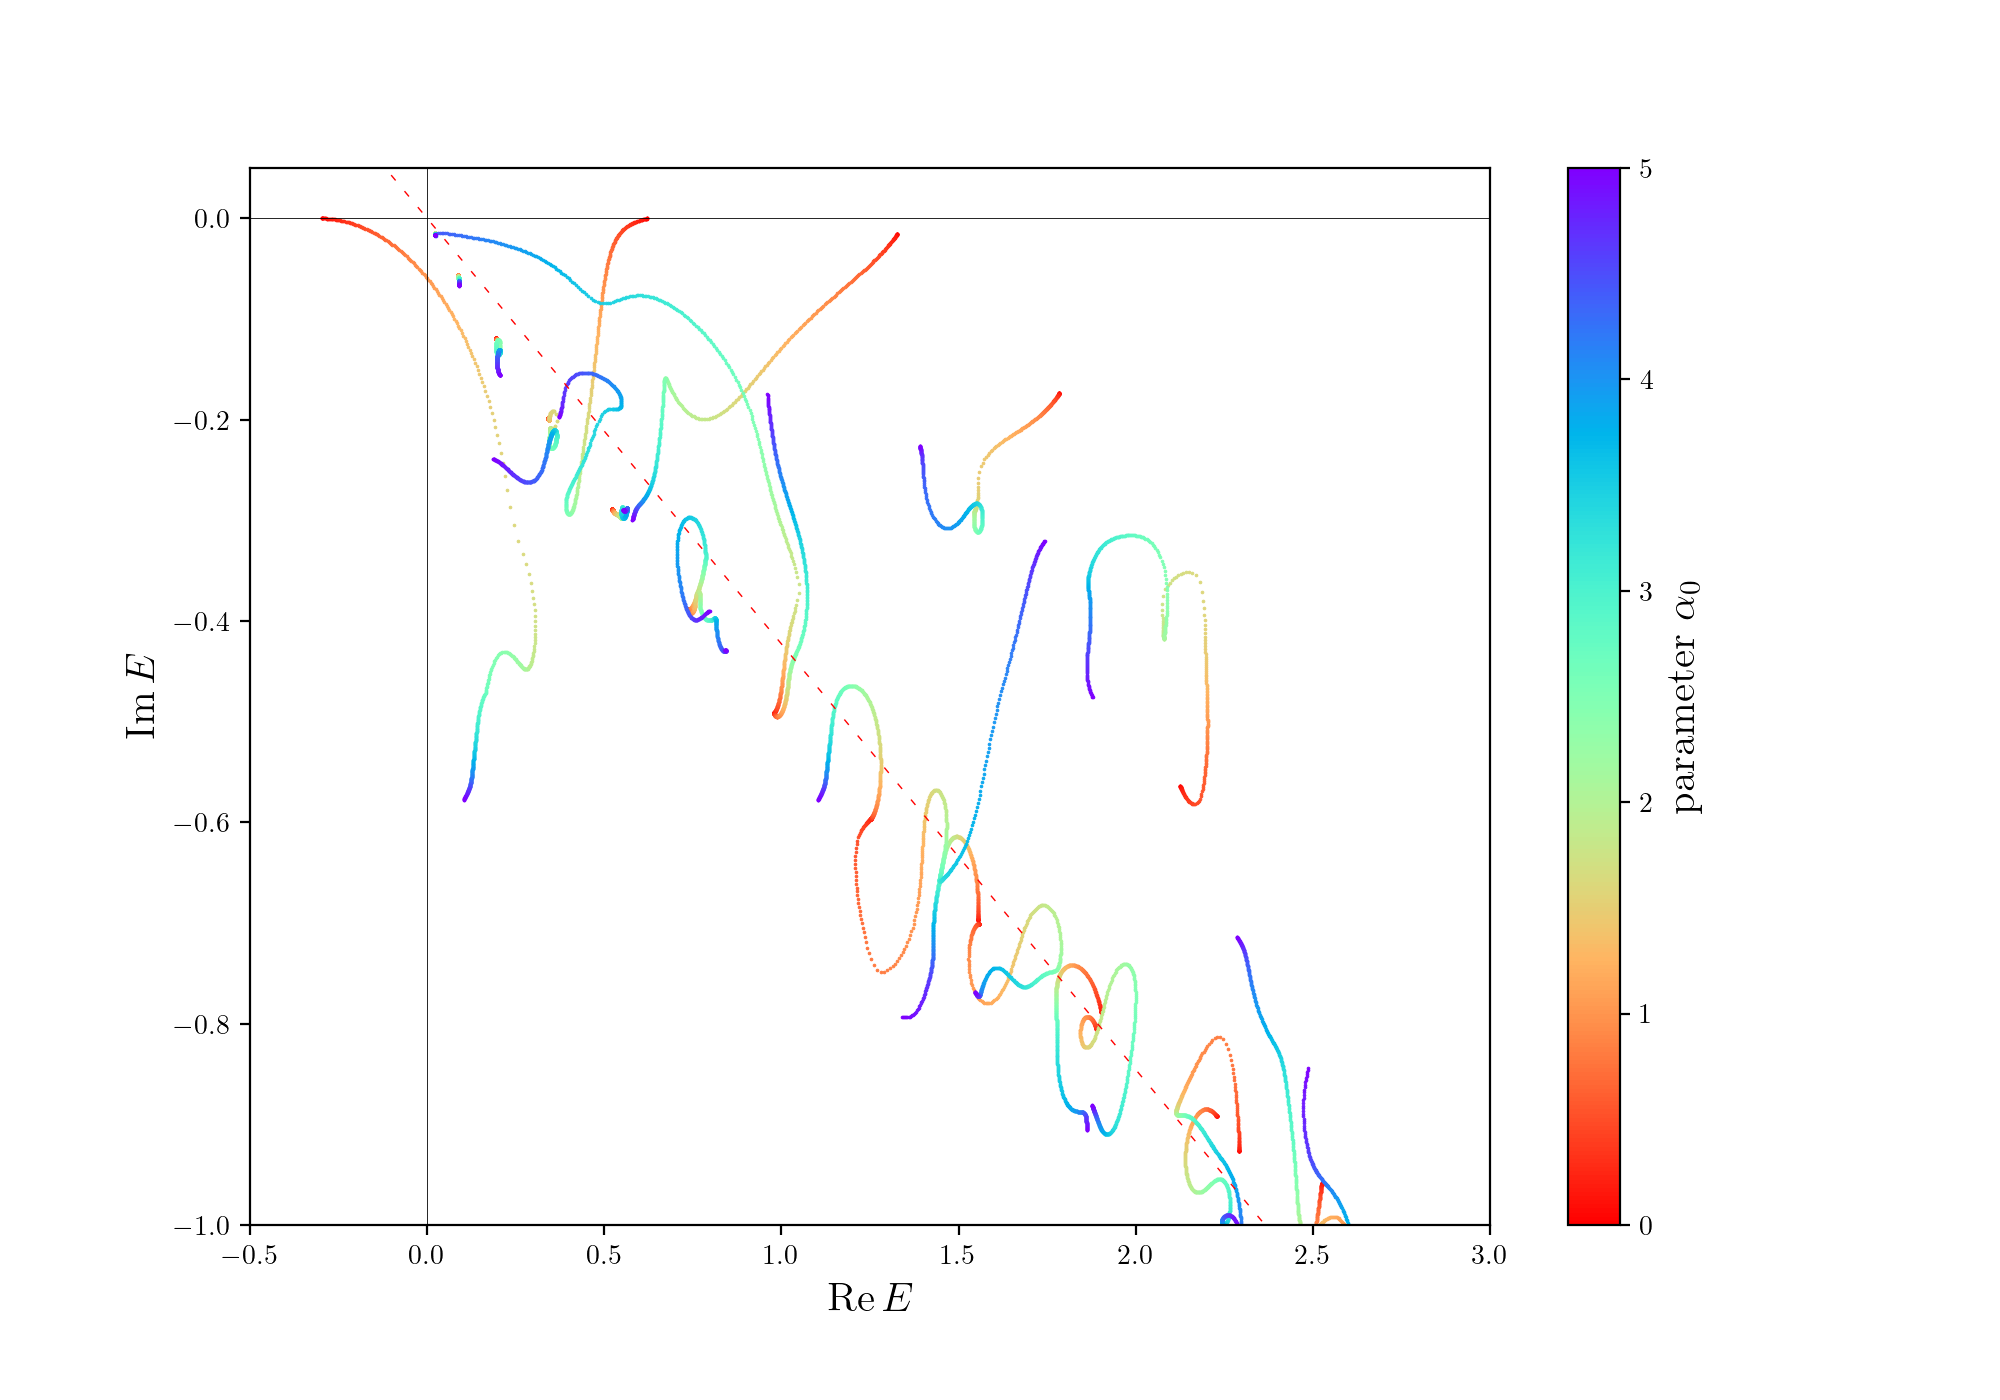

In [262]:
%matplotlib widget
from matplotlib import cm
import matplotlib.cm as cmx
import matplotlib.colors as colors

fig, ax = plt.subplots(num=None, figsize=(10,7), dpi=200, facecolor='w', edgecolor='k')

nsteps = 500
stepsize = 0.01

cmap = plt.get_cmap('rainbow_r')
cNorm  = colors.Normalize(vmin=0, vmax=nsteps*stepsize)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cmap)


nu_range = np.arange(*nus + np.array([0,1]))

Hp_diag_shift = np.identity(nu_range.size) * nu_range
Hp_diag = np.identity(nu_range.size)
Hp_offdiag = (np.eye(nu_range.size,k=1) + np.eye(nu_range.size, k=-1))

xdat = cline(np.linspace(-1,4, 1000), F_theta)
plt.plot(np.real(xdat), np.imag(xdat), linestyle = (0,(5,10)), color= "r", linewidth=0.5)

pre_NHF = np.kron(Hp_diag, CNI_results) + np.kron(Hp_diag_shift, np.identity(Nbas) * omega)

reference = CeNI

for n in tqdm(range(nsteps)):
    alpha = n * stepsize 
    NHF_Hp_total =  pre_NHF + np.kron(Hp_offdiag, NHF_results) * alpha / 2.0
    NHF_eig_vals, NHF_eig_vects = np.linalg.eig(NHF_Hp_total) 

    #data = NHF_eig_vals.reshape([nu_range.size,Nbas])
    
    data = list()
    for idx,i in enumerate(reference):
        df = np.abs(NHF_eig_vals - i)
        mindf = np.argmin(df)
        data.append([idx, NHF_eig_vals[mindf]])
    data = np.array(data).T
    
    #plt.scatter(np.real(data[Nnus+1]), np.imag(data[Nnus+1]), s=1, marker='o',linewidth=0.3, color=scalarMap.to_rgba(n))
    plt.scatter(np.real(data[1]), np.imag(data[1]), s=1, marker='o',linewidth=0.3, color=scalarMap.to_rgba(n*stepsize))
    reference = data[1]

#plt.scatter(np.real(CeNI), np.imag(CeNI), s=4, marker='x',linewidth=0.4, color="red")

plt.plot([-15,15],[0,0],color='k',linewidth=0.3)
plt.plot([0,0],[-15,15],color='k',linewidth=0.3)
     
plt.xlim(-0.5, 3)
plt.ylim(-1,0.05)
plt.xlabel(r"$\Re E$",fontsize=15)
plt.ylabel(r"$\Im E$",fontsize=15)

cb = fig.colorbar(cm.ScalarMappable(norm=cNorm, cmap=cmap), ax=ax)
cb.set_label(label=r"$\textrm{parameter } \alpha_0$", fontsize=15)
#plt.clim([0, nsteps*stepsize])
plt.show()

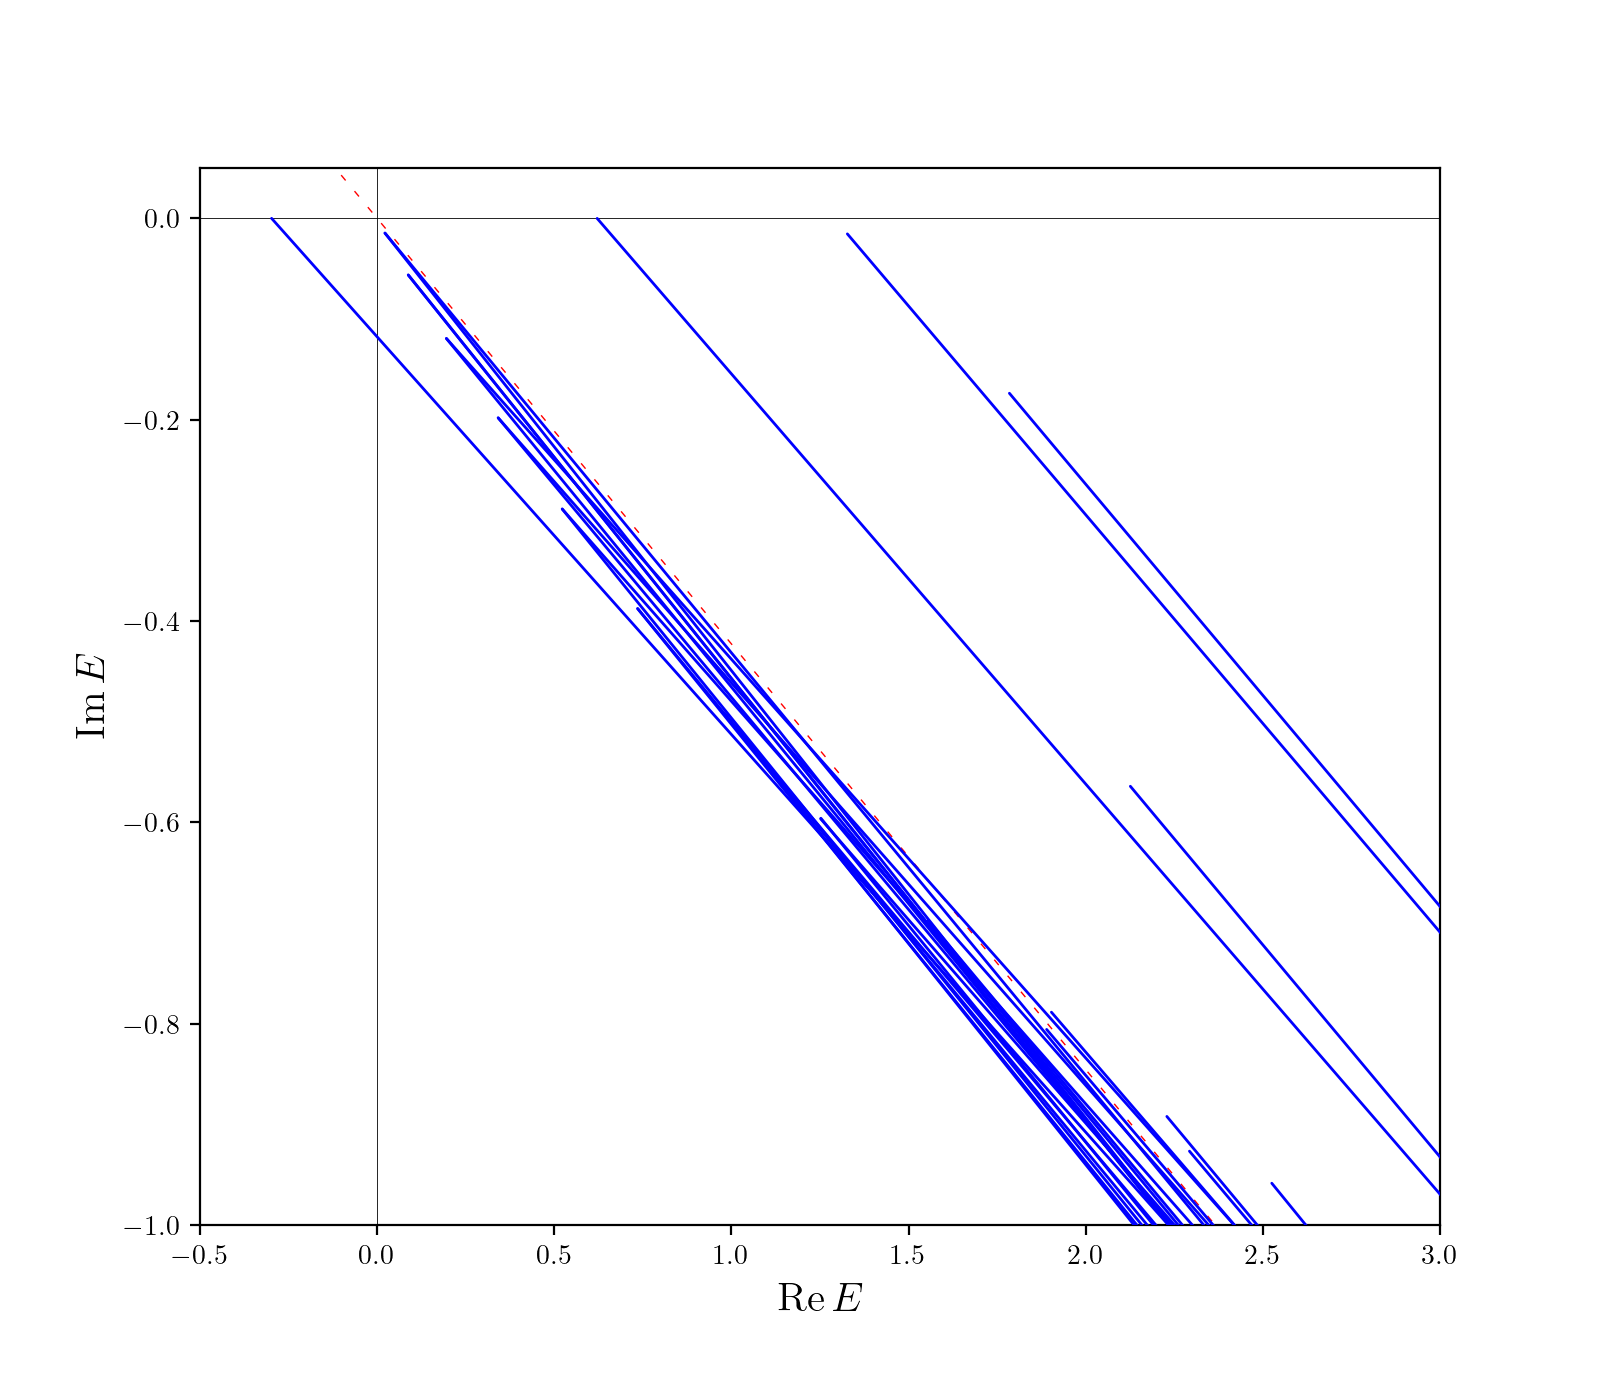

In [280]:
%matplotlib widget
#%matplotlib inline
ig, ax = plt.subplots(num=None, figsize=(8,7), dpi=200, facecolor='w', edgecolor='k')

xdat = cline(np.linspace(-1,4, 1000), F_theta)
plt.plot(np.real(xdat), np.imag(xdat), linestyle = (0,(5,10)), color= "r", linewidth=0.5)

for a,b in zip(CeNI, data[1]):
    #plt.arrow(np.real(a), np.imag(a), np.real(b-a), np.imag(b-a), head_width=0.03, head_length=0.03)
    if np.abs(b-a) > 0.03:
        prop = dict(arrowstyle="->,head_width=0.15,head_length=0.5", shrinkA=0, shrinkB=0, color='blue') 
    else:
        prop = dict(arrowstyle="-", color='blue')
    ann = plt.annotate("", xytext=(np.real(a), np.imag(a)), xy=(np.real(b), np.imag(b)), arrowprops=prop, annotation_clip=False, )   
    ann.arrow_patch.set_clip_box(ax.bbox)
    
plt.plot([-15,15],[0,0],color='k',linewidth=0.3)
plt.plot([0,0],[-15,15],color='k',linewidth=0.3)
     

plt.xlim(-0.5, 3)
plt.ylim(-1,0.05)
plt.xlabel(r"$\Re E$",fontsize=15)
plt.ylabel(r"$\Im E$",fontsize=15)

plt.show()

In [40]:
u,uu = list(zip(CeNI, data[1]))[0]
u, uu-u

((-0.29795963785803337-1.8572876242877856e-14j),
 (0.12074282076703602-0.009665993272191082j))

In [275]:
out = list()

for i in CeNI:
    df = np.abs(NHF_eig_vals - i)
    mindf = np.argmin(df)
    out.append([i, NHF_eig_vals[mindf]])
    
out = np.array(out).T

In [276]:
import matplotlib.cm as cmx
import matplotlib.colors as colors

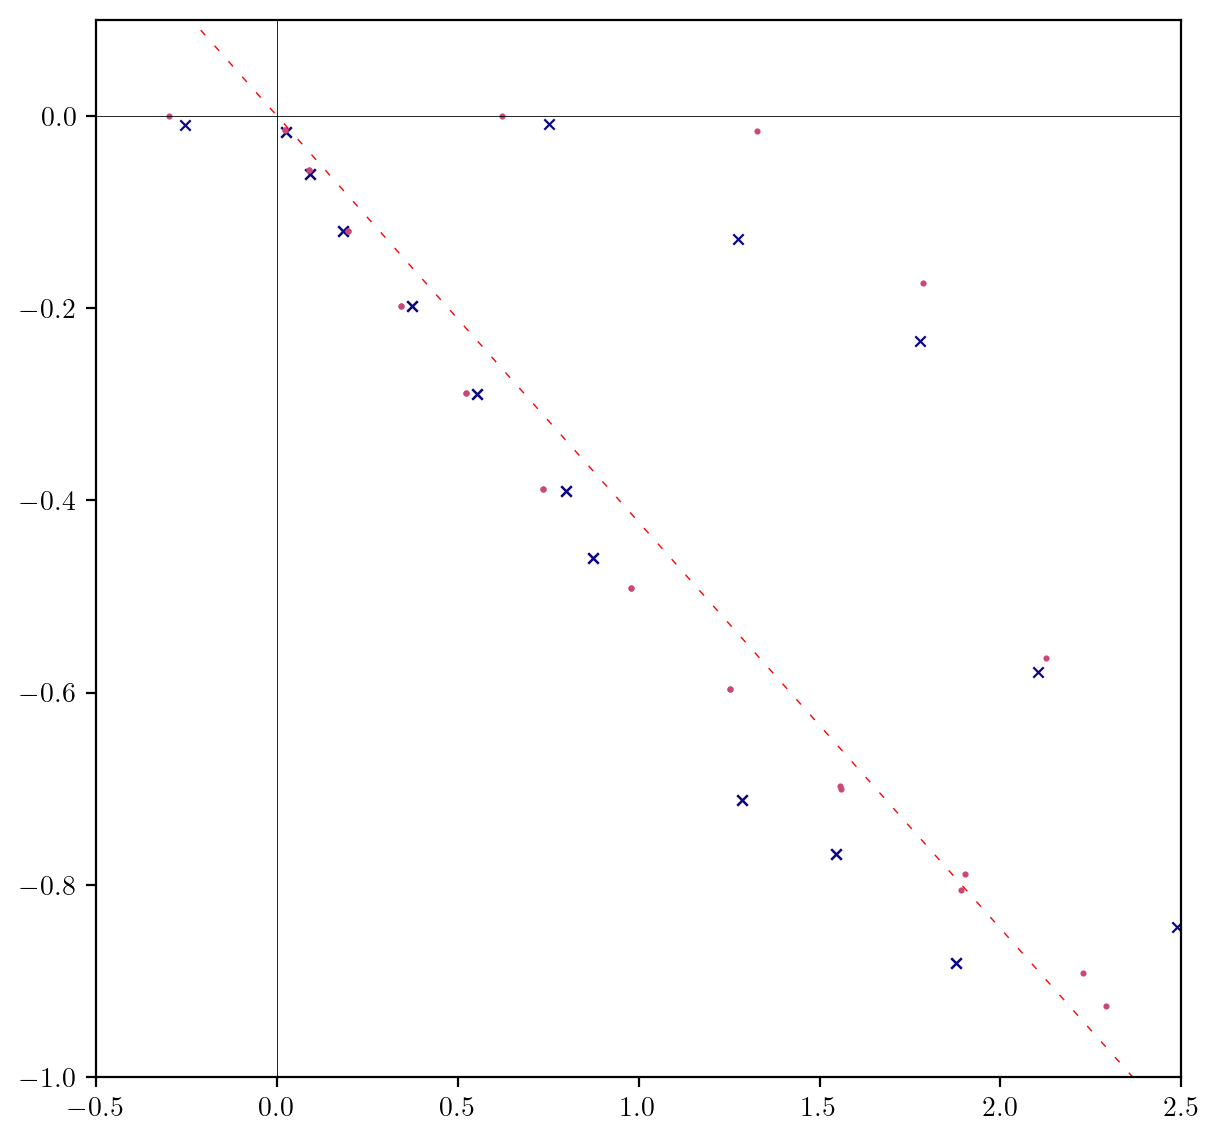

In [277]:
fig, ax = plt.subplots(num=None, figsize=(7,7), dpi=200, facecolor='w', edgecolor='k')

xdat = cline(np.linspace(-1,4, 1000), F_theta)
plt.plot(np.real(xdat), np.imag(xdat), linestyle = (0,(5,10)), color= "r", linewidth=0.5)

# for i,line in enumerate(NHF_eig_vals.reshape([nu_range.size,Nbas])):
#     if i != Nnus:
#         continue
#     plt.scatter(np.real(line), np.imag(line), s=14, marker='x',linewidth=0.8)
#     plt.plot([-15,15],[0,0],color='k',linewidth=0.3)
#     plt.plot([0,0],[-15,15],color='k',linewidth=0.3)

 
jet = plt.get_cmap('plasma')
cNorm  = colors.Normalize(vmin=0, vmax=200)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)


data = NHF_eig_vals.reshape([nu_range.size,Nbas])
q = 1
#plt.scatter(np.real(data[Nnus+q]), np.imag(data[Nnus+q]), s=14, marker='x',linewidth=0.8, color=scalarMap.to_rgba(0))
plt.scatter(np.real(out[1]), np.imag(out[1]), s=14, marker='x',linewidth=0.8, color=scalarMap.to_rgba(0))


###
#plt.scatter(np.real(data[Nnus+1]), np.imag(data[Nnus+1]), s=14, marker='x',linewidth=0.8)
#plt.scatter(np.real(dat0[Nnus+6]), np.imag(dat0[Nnus+1]), s=14, marker='x',linewidth=0.8)
plt.scatter(np.real(Cevals), np.imag(Cevals),s=2, marker='o',linewidth=0.8,color=scalarMap.to_rgba(100))
###


#plt.scatter(np.sort(np.real(dat0[Nnus]))[0], np.imag(dat0[Nnus])[np.argsort(np.real(dat0[Nnus]))][0], s=2, marker='o',color='r',linewidth=0.8)
plt.plot([-15,15],[0,0],color='k',linewidth=0.3)
plt.plot([0,0],[-15,15],color='k',linewidth=0.3)
     
plt.xlim(-0.5, 2.5)
plt.ylim(-1,0.1)
plt.show()

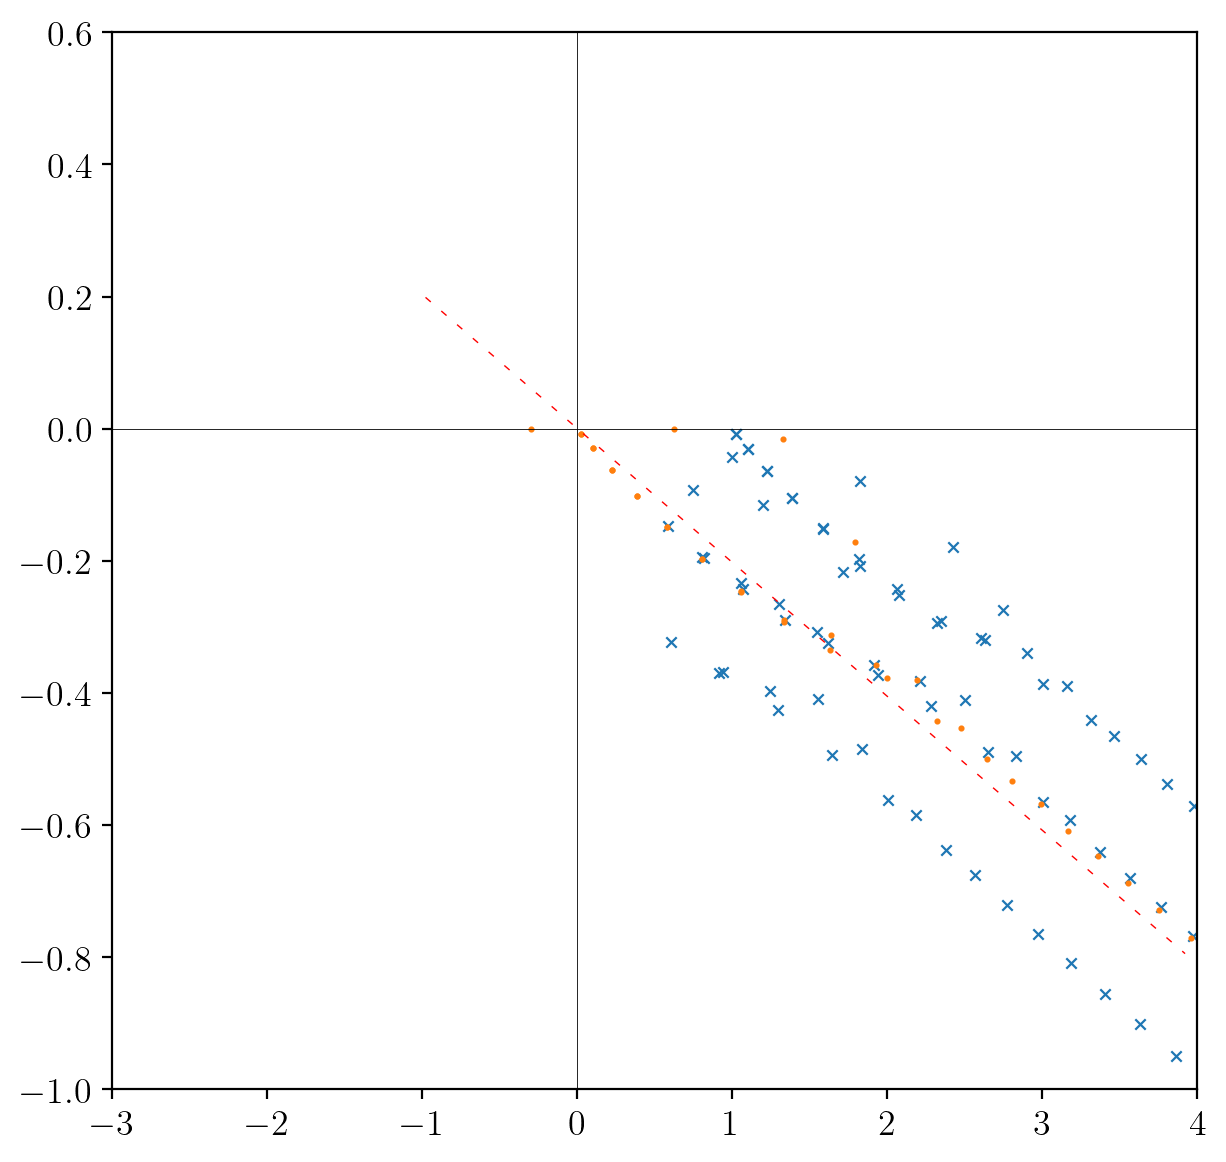

In [215]:
fig, ax = plt.subplots(num=None, figsize=(7,7), dpi=200, facecolor='w', edgecolor='k')

xdat = cline(np.linspace(-1,4, 1000), F_theta)
plt.plot(np.real(xdat), np.imag(xdat), linestyle = (0,(5,10)), color= "r", linewidth=0.5)

# for i,line in enumerate(NHF_eig_vals.reshape([nu_range.size,Nbas])):
#     if i != Nnus:
#         continue
#     plt.scatter(np.real(line), np.imag(line), s=14, marker='x',linewidth=0.8)
#     plt.plot([-15,15],[0,0],color='k',linewidth=0.3)
#     plt.plot([0,0],[-15,15],color='k',linewidth=0.3)

data = NHF_eig_vals.reshape([nu_range.size,Nbas])
q = 1
plt.scatter(np.real(data[Nnus+q]), np.imag(data[Nnus+q]), s=14, marker='x',linewidth=0.8)

###
#plt.scatter(np.real(data[Nnus+1]), np.imag(data[Nnus+1]), s=14, marker='x',linewidth=0.8)
#plt.scatter(np.real(dat0[Nnus+6]), np.imag(dat0[Nnus+1]), s=14, marker='x',linewidth=0.8)
plt.scatter(np.real(Cevals), np.imag(Cevals),s=2, marker='o',linewidth=0.8)
###


#plt.scatter(np.sort(np.real(dat0[Nnus]))[0], np.imag(dat0[Nnus])[np.argsort(np.real(dat0[Nnus]))][0], s=2, marker='o',color='r',linewidth=0.8)
plt.plot([-15,15],[0,0],color='k',linewidth=0.3)
plt.plot([0,0],[-15,15],color='k',linewidth=0.3)
     
plt.xlim(-3, 4)
plt.ylim(-1,0.6)
plt.show()

# Exceptional points

In [281]:
data0 = NHF_eig_vals.reshape([nu_range.size, Nbas])[Nnus]
data1 = NHF_eig_vals.reshape([nu_range.size, Nbas])[Nnus + 1]

In [282]:
vects = np.load("C:/Users/micha/Downloads/vects_1_Nbas-200_Nnus-6_th-02_nst-400_stsize-0005_om-1_ID-01-10.npy")
vals = np.load("C:/Users/micha/Downloads/vals_1_Nbas-200_Nnus-6_th-02_nst-400_stsize-0005_om-1_ID-01-10.npy")
alphas = np.load("C:/Users/micha/Downloads/valphas_1_Nbas-200_Nnus-6_th-02_nst-400_stsize-0005_om-1_ID-01-10.npy")

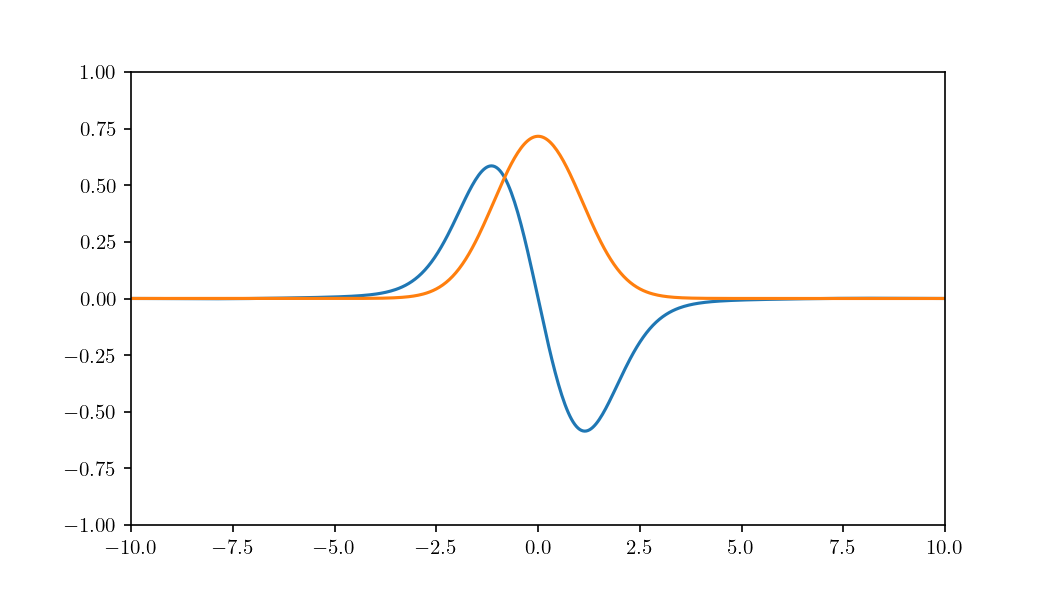

In [283]:
vect0 = vects[0]
vA, vB = vect0
vX = np.reshape(vA, (2*Nnus+1, Nbas ))
vY = np.reshape(vB, (2*Nnus+1, Nbas ))

xax = np.linspace(-20,20,1000)
forplot = np.zeros_like(xax, dtype=complex)

idx = np.arange(1, Nbas+1, 1, dtype=int)
fig, ax = plt.subplots(num=None, figsize=(7,4), dpi=150, facecolor='w', edgecolor='k')

for vQ in (vX[Nnus], vY[Nnus+1]):
    for i,x in enumerate(xax):
        v = basisf(x=x, nu=idx) * vQ
        isuma = np.sum(np.imag(v))
        rsuma = np.sum(np.real(v))
        forplot[i] = rsuma + 1j*isuma

    plt.plot(xax, np.real(forplot))

plt.xlim(-10,10)
plt.ylim(-1,1)
plt.show()

In [18]:
vals

array([[0.        +0.00000000e+00j, 0.62097095-5.82830268e-05j,
        0.70204036-1.74795482e-14j],
       [0.005     +0.00000000e+00j, 0.62094706-6.03847345e-05j,
        0.70206854-4.14939478e-08j],
       [0.01      +0.00000000e+00j, 0.62087549-6.66817229e-05j,
        0.70215298-1.74660327e-07j],
       ...,
       [1.985     +0.00000000e+00j, 0.42578686-2.64754206e-01j,
        1.28320403-4.47390213e-01j],
       [1.99      +0.00000000e+00j, 0.42547035-2.65479309e-01j,
        1.28269322-4.47509535e-01j],
       [1.995     +0.00000000e+00j, 0.42515495-2.66195823e-01j,
        1.28218157-4.47613721e-01j]])

In [284]:
def sumator(x, idx, vec):
    v = basisf(x=x, nu=idx) * vec
    isuma = np.sum(np.imag(v))
    rsuma = np.sum(np.real(v))
    return rsuma + 1j*isuma

In [285]:
Lhalf = p['x_max']
idx = np.arange(1, Nbas+1, 1, dtype=int)
func = lambda x: sumator(x, idx, vX[Nnus]) * sumator(x, idx, vY[Nnus+1]) * potential_prime(x * np.exp(1.0j * 0.2))

dV_real = integrate.quad(lambda x: np.real(func(x)), -Lhalf, Lhalf, limit=400)[0]
dV_imag = integrate.quad(lambda x: np.imag(func(x)), -Lhalf, Lhalf, limit=400)[0]

EP_D = dV_real + 1.0j * dV_imag
EP_DR = np.real(EP_D)
EP_DI = np.imag(EP_D)
EP_D

(-0.5649404602177808-0.13077996773884581j)

In [286]:
EP_EB = np.real(vals[0,2])
EP_ER = np.real(vals[0,1])
EP_G = 1j * np.imag(vals[0,1])
EP_omega = 1
EP_alpha = (EP_ER - 1j * EP_G/2 - EP_EB - hbar * EP_omega)*(EP_DI + 1j * EP_DR)/(EP_DR**2 + EP_DI**2) 

EP_A = (EP_ER - 1j/2 * EP_G + EP_EB + hbar * EP_omega)
EP_B = -(EP_EB + hbar * EP_omega) + EP_A

In [287]:
A = EP_EB + hbar*EP_omega
B = EP_alpha / 2 * EP_D
C = EP_ER - 1j * EP_G/2

matx = np.array([[A, B],[B, C]])

In [288]:
EP_vals, EP_vects = np.linalg.eig(matx)
EP_vals, EP_vects

(array([1.16149107+0.j, 1.1614911 +0.j]),
 array([[-0.        +0.70710677j,  0.70710679+0.j        ],
        [ 0.70710679+0.j        , -0.        -0.70710677j]]))

In [53]:
EP_vects[1]*1j

array([0.        +0.70710679j, 0.70710677-0.j        ])

In [54]:
EP_alpha

(0.4204650026276935+1.816315573378164j)

In [289]:
def pert_mat(mat, pertub):
    m = mat + (np.eye(2,k=1) + np.eye(2,k=-1)) * pertub
    return np.linalg.eig(m)

def center(vect):
    x1, x2 = vect
    dx = np.subtract(x2,x1)
    cent = dx/2 + x1
    return np.subtract(vect,cent) / np.abs(dx)

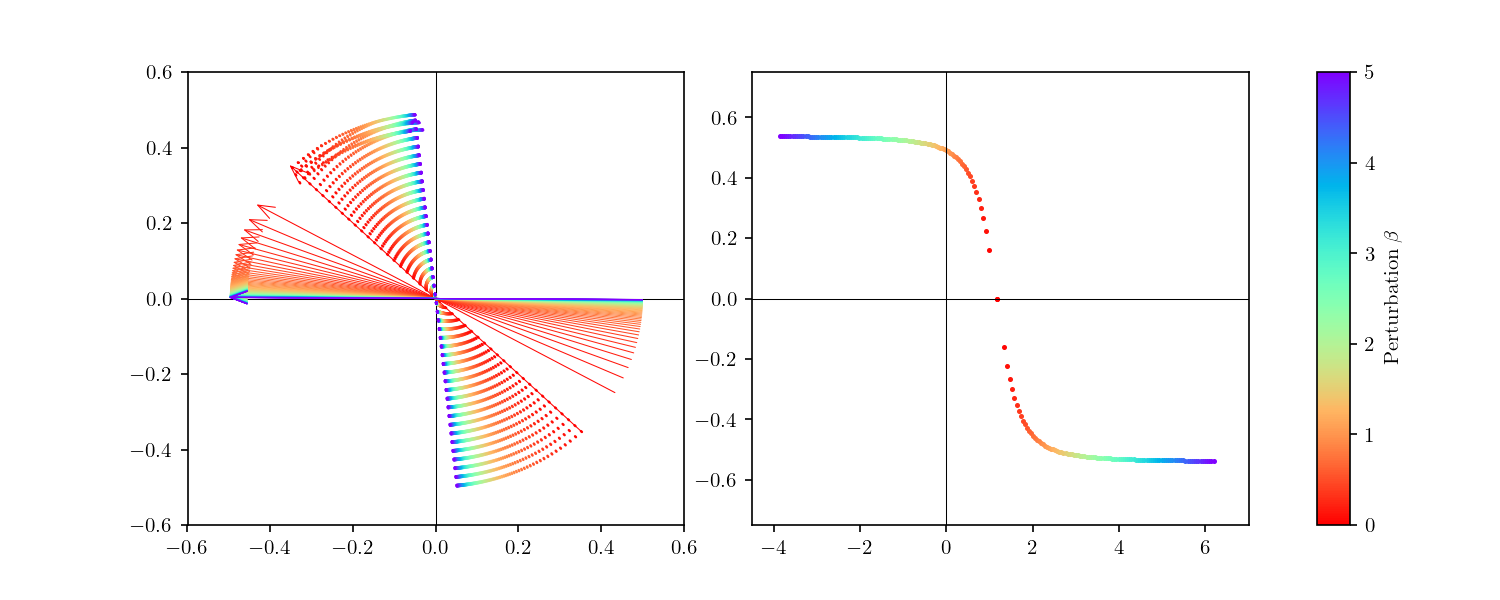

In [290]:
fig, ax = plt.subplots(figsize=(10,4), sharey=True, dpi=150, facecolor='w', edgecolor='k')
gs = gridspec.GridSpec(ncols=3, nrows=1, width_ratios=[15,15,1], figure=fig) 

ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[2])

nn = 100
nmin = 0
nmax = 5

cm1 = plt.get_cmap('rainbow_r')
cn1  = colors.Normalize(vmin=nmin, vmax=nmax)
scm1 = cmx.ScalarMappable(norm=cn1, cmap=cm1)

for numb in np.linspace(nmin, nmax, nn):
    cc = 1 
    if numb == 0:
        cc = -1
        
    (vh1, vh2), (va, vb) = pert_mat(matx, numb)
    pr = dict(arrowstyle="->,head_width=0.3,head_length=0.8", shrinkA=0, shrinkB=0, color=scm1.to_rgba(np.real(numb)), linewidth=0.5) 
    
    vv = center(va) *cc
    
    ax0.annotate("", xytext=(np.real(vv[0]), np.imag(vv[0])), xy=(np.real(vv[1]), np.imag(vv[1])), arrowprops=pr)
    
    vv = center(vb*1j) *cc
    
    pr.update(dict(linestyle=(0, (0.5,3)), linewidth=1.2))
    ax0.annotate("", xytext=(np.real(vv[0]), np.imag(vv[0])), xy=(np.real(vv[1]), np.imag(vv[1])), arrowprops=pr)
    
    ax1.scatter(np.real(vh1), np.imag(vh1), color=scm1.to_rgba(np.real(numb)), s=2)
    ax1.scatter(np.real(vh2), np.imag(vh2), color=scm1.to_rgba(np.real(numb)), s=2)
    
ax0.plot([0,0], [-1,1], color='black', linewidth=0.5)
ax0.plot([-1,1], [0,0], color='black', linewidth=0.5)
ax1.plot([0,0], [-1,1], color='black', linewidth=0.5)
ax1.plot([-10,10], [0,0], color='black', linewidth=0.5)

ax0.set_xlim(-0.6,0.6)
ax0.set_ylim(-0.6,0.6)

ax1.set_xlim(-4.5,7)
ax1.set_ylim(-0.75,0.75)

ax.set_ylabel("$\\textrm{Im}$")
ax.set_xlabel("$\\textrm{Re}$")

plt.colorbar(cm.ScalarMappable(norm=cn1, cmap=cm1), ax=ax0, cax=ax2, label="$\\textrm{Perturbation}\\ \\beta$")


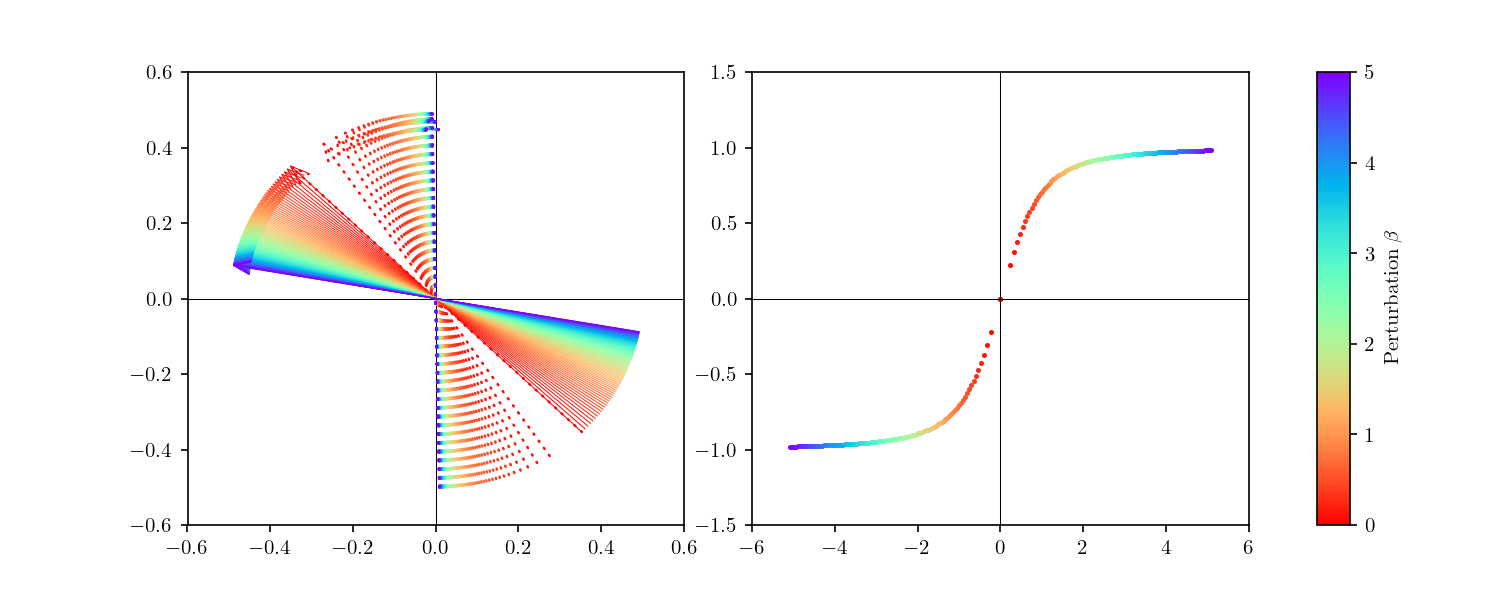

In [291]:
fig, ax = plt.subplots(figsize=(10,4), sharey=True, dpi=150, facecolor='w', edgecolor='k')
gs = gridspec.GridSpec(ncols=3, nrows=1, width_ratios=[15,15,1], figure=fig) 

ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[2])

nn = 100
nmin = 0
nmax = 5

matx_dummy = np.array([[-1, 1j],[1j, 1]], dtype=complex)

cm1 = plt.get_cmap('rainbow_r')
cn1  = colors.Normalize(vmin=nmin, vmax=nmax)
scm1 = cmx.ScalarMappable(norm=cn1, cmap=cm1)

for numb in np.linspace(nmin, nmax, nn):
    cc = 1 
    if numb == 0:
        cc = -1
        
    (vh1, vh2), (va, vb) = pert_mat(matx_dummy, numb)
    pr = dict(arrowstyle="->,head_width=0.3,head_length=0.8", shrinkA=0, shrinkB=0, color=scm1.to_rgba(np.real(numb)), linewidth=0.5) 
    
    vv = center(va) *cc
    
    ax0.annotate("", xytext=(np.real(vv[0]), np.imag(vv[0])), xy=(np.real(vv[1]), np.imag(vv[1])), arrowprops=pr)
    
    vv = center(vb*1j) *cc
    
    pr.update(dict(linestyle=(0, (0.5,3)), linewidth=1.2))
    ax0.annotate("", xytext=(np.real(vv[0]), np.imag(vv[0])), xy=(np.real(vv[1]), np.imag(vv[1])), arrowprops=pr)
    
    ax1.scatter(np.real(vh1), np.imag(vh1), color=scm1.to_rgba(np.real(numb)), s=2)
    ax1.scatter(np.real(vh2), np.imag(vh2), color=scm1.to_rgba(np.real(numb)), s=2)
    
ax0.plot([0,0], [-1,1], color='black', linewidth=0.5)
ax0.plot([-1,1], [0,0], color='black', linewidth=0.5)
ax1.plot([0,0], [-2,2], color='black', linewidth=0.5)
ax1.plot([-10,10], [0,0], color='black', linewidth=0.5)

ax0.set_xlim(-0.6,0.6)
ax0.set_ylim(-0.6,0.6)

ax1.set_xlim(-6, 6)
ax1.set_ylim(-1.5, 1.5)

ax.set_ylabel("$\\textrm{Im}$")
ax.set_xlabel("$\\textrm{Re}$")

plt.colorbar(cm.ScalarMappable(norm=cn1, cmap=cm1), ax=ax0, cax=ax2, label="$\\textrm{Perturbation}\\ \\beta$")


In [293]:
def sort_evals(last, current):
    dx = np.subtract(current, last)
    if np.max(np.abs(dx)) > 1:
        return [1,0]
    else:
        return [0,1]

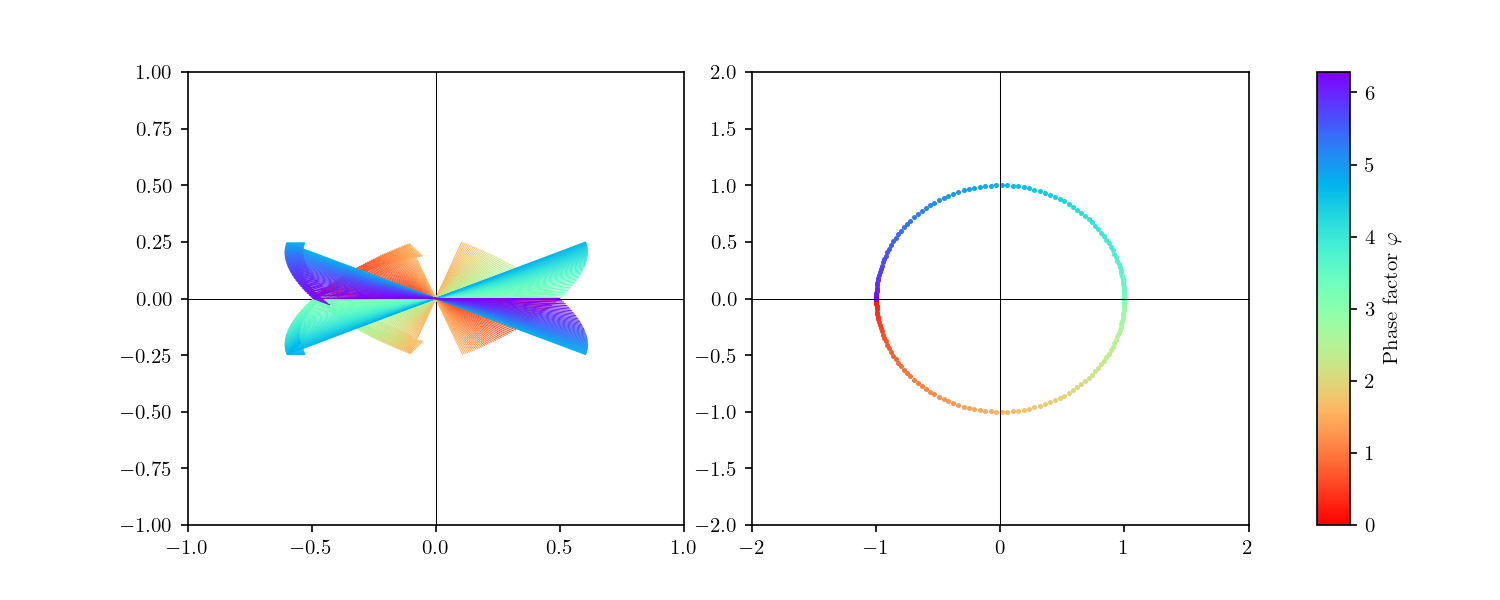

In [294]:
fig, ax = plt.subplots(figsize=(10,4), sharey=True, dpi=150, facecolor='w', edgecolor='k')
gs = gridspec.GridSpec(ncols=3, nrows=1, width_ratios=[15,15,1], figure=fig) 


def center2(vect):
    x1, x2 = vect
    dx = np.subtract(x2,x1)
    cent = dx/2 + x1
    return np.subtract(vect,cent) #/ np.abs(dx)

def pert_mat2(mat, phi, z=1):
    off = np.array([[0,1],[1,0]], dtype=complex)
    realp = np.sin(2*phi)/2
    imagp = -1 + np.abs(np.sin(phi)) * np.sqrt(1 + np.sin(phi)**2)
    #imagp = -1 - np.abs(np.sin(phi)) * np.sqrt(1 + np.sin(phi)**2)
    #imagp = -1 + np.sin(phi) * np.sqrt(1 + np.sin(phi)**2)
    m = mat + off * realp + off * imagp * 1j
    return np.linalg.eig(m)

def pert_mat3(mat, phi, z=1):
    off = np.array([[0,1],[1,0]], dtype=complex)
    az = np.abs(z)
    cphq = (np.cos(phi))**2
    sphq = (np.sin(phi))**2
    realp = az**2 /2 * np.sin(2*phi)
    imagp = -1 + np.sqrt( 1 - az**2 * (2*cphq -1 - az**2 * cphq * sphq ))
    m = mat + off * realp + off * imagp * 1j
    return np.linalg.eig(m)

ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[2])

nn = 200
nmin = 0
nmax = 2*np.pi

matx_dummy = np.array([[-1, 1j],[1j, 1]], dtype=complex)

cm1 = plt.get_cmap('rainbow_r')
cn1  = colors.Normalize(vmin=nmin, vmax=nmax)
scm1 = cmx.ScalarMappable(norm=cn1, cmap=cm1)
last_vh = np.array([0,0],dtype=complex)

for numb in np.linspace(nmin, nmax, nn):
    vh, vv = pert_mat2(matx_dummy, numb)
    
    order = sort_evals(last_vh, vh)
    #print(order)
    vh1, vh2 = vh[order]
    va, vb = vv[order] 
    last_vh = vh[order]
    
    #print(vh1,vh2, va, vb)
    pr = dict(arrowstyle="->,head_width=0.3,head_length=0.8", shrinkA=0, shrinkB=0, color=scm1.to_rgba(np.real(numb)), linewidth=0.5) 
    
    vv = center2(-va*np.sign(np.real(vh1)))
    
    ax0.annotate("", xytext=(np.real(vv[0]), np.imag(vv[0])), xy=(np.real(vv[1]), np.imag(vv[1])), arrowprops=pr)
    
    vv = center2(vb)
    
    pr.update(dict(linestyle=(0, (0.5,3)), linewidth=1.2))
    #ax0.annotate("", xytext=(np.real(vv[0]), np.imag(vv[0])), xy=(np.real(vv[1]), np.imag(vv[1])), arrowprops=pr)
    
    ax1.scatter(np.real(vh1), np.imag(vh1), color=scm1.to_rgba(np.real(numb)), s=2)
    #ax1.scatter(np.real(vh2), np.imag(vh2), color=scm1.to_rgba(np.real(numb)), s=3,)
    
ax0.plot([0,0], [-1,1], color='black', linewidth=0.5)
ax0.plot([-1,1], [0,0], color='black', linewidth=0.5)
ax1.plot([0,0], [-2,2], color='black', linewidth=0.5)
ax1.plot([-10,10], [0,0], color='black', linewidth=0.5)

ax0.set_xlim(-1,1)
ax0.set_ylim(-1,1)

ax1.set_xlim(-2, 2)
ax1.set_ylim(-2, 2)

ax.set_ylabel("$\\textrm{Im}$")
ax.set_xlabel("$\\textrm{Re}$")

plt.colorbar(cm.ScalarMappable(norm=cn1, cmap=cm1), ax=ax0, cax=ax2, label="$\\textrm{Phase\\ factor}\\ \\varphi$")


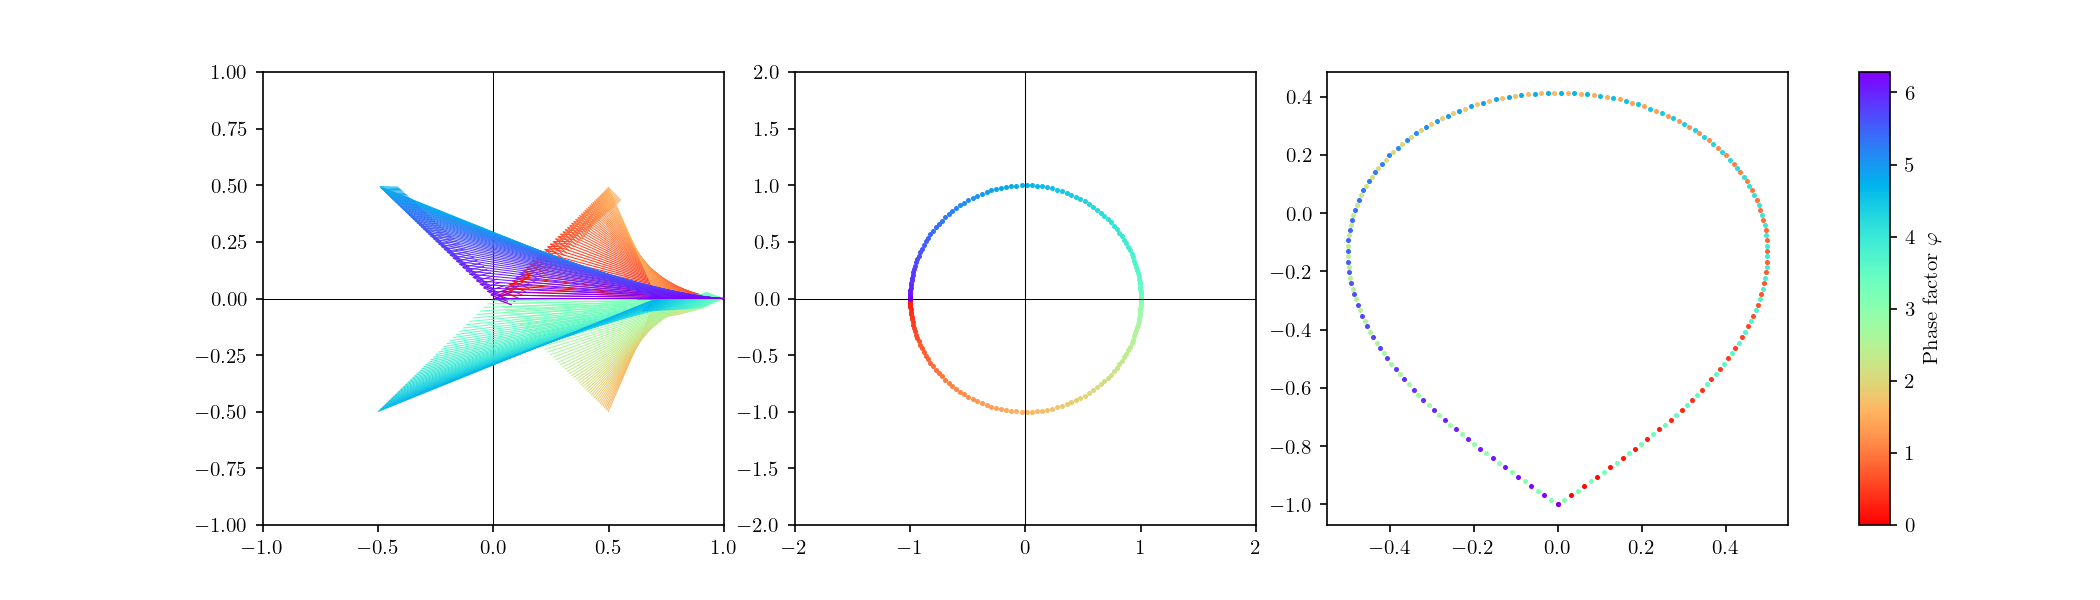

In [295]:
fig, ax = plt.subplots(figsize=(14,4), sharey=True, dpi=150, facecolor='w', edgecolor='k')
gs = gridspec.GridSpec(ncols=4, nrows=1, width_ratios=[15,15,15,1], figure=fig) 


def center2(vect):
    x1, x2 = vect
    dx = np.subtract(x2,x1)
    cent = dx/2 + x1
    return np.subtract(vect,cent) #/ np.abs(dx)

def pert_mat2(mat, phi, z=1):
    off = np.array([[0,1],[1,0]], dtype=complex)
    realp = np.sin(2*phi)/2
    imagp = -1 + np.abs(np.sin(phi)) * np.sqrt(1 + np.sin(phi)**2)
    #imagp = -1 - np.abs(np.sin(phi)) * np.sqrt(1 + np.sin(phi)**2)
    #imagp = -1 + np.sin(phi) * np.sqrt(1 + np.sin(phi)**2)
    m = mat + off * realp + off * imagp * 1j
    return np.linalg.eig(m)

def pert_mat3(mat, phi, z=1):
    off = np.array([[0,1],[1,0]], dtype=complex)
    az = np.abs(z)
    cphq = (np.cos(phi))**2
    sphq = (np.sin(phi))**2
    realp = az**2 /2 * np.sin(2*phi)
    imagp = -1 + np.sqrt( 1 - az**2 * (2*cphq -1 - az**2 * cphq * sphq ))
    m = mat + off * realp + off * imagp * 1j
    return np.linalg.eig(m)

ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[2])
ax3 = plt.subplot(gs[3])

nn = 200
nmin = 0
nmax = 2*np.pi

matx_dummy = np.array([[-1, 1j],[1j, 1]], dtype=complex)

cm1 = plt.get_cmap('rainbow_r')
cn1  = colors.Normalize(vmin=nmin, vmax=nmax)
scm1 = cmx.ScalarMappable(norm=cn1, cmap=cm1)
last_vh = np.array([0,0],dtype=complex)

for numb in np.linspace(nmin, nmax, nn):
    vh, vv = pert_mat2(matx_dummy, numb)
    
    order = sort_evals(last_vh, vh)
    #print(order)
    vh1, vh2 = vh[order]
    va, vb = vv[order] 
    last_vh = vh[order]
    
    #print(vh1,vh2, va, vb)
    pr = dict(arrowstyle="->,head_width=0.3,head_length=0.8", shrinkA=0, shrinkB=0, color=scm1.to_rgba(np.real(numb)), linewidth=0.5) 
    
    vv = va #center2(-va*np.sign(np.real(vh1)))
    
    ax0.annotate("", xytext=(np.real(vv[0]), np.imag(vv[0])), xy=(np.real(vv[1]), np.imag(vv[1])), arrowprops=pr)
    
    vv = center2(vb)
    
    pr.update(dict(linestyle=(0, (0.5,3)), linewidth=1.2))
    #ax0.annotate("", xytext=(np.real(vv[0]), np.imag(vv[0])), xy=(np.real(vv[1]), np.imag(vv[1])), arrowprops=pr)
    
    ax1.scatter(np.real(vh1), np.imag(vh1), color=scm1.to_rgba(np.real(numb)), s=2)
    #ax1.scatter(np.real(vh2), np.imag(vh2), color=scm1.to_rgba(np.real(numb)), s=3,)
    
    ax2.scatter(np.sin(2*numb)/2, -1 + np.abs(np.sin(numb)) * np.sqrt(1 + np.sin(numb)**2), color=scm1.to_rgba(np.real(numb)), s=2)
    
ax0.plot([0,0], [-1,1], color='black', linewidth=0.5)
ax0.plot([-1,1], [0,0], color='black', linewidth=0.5)
ax1.plot([0,0], [-2,2], color='black', linewidth=0.5)
ax1.plot([-10,10], [0,0], color='black', linewidth=0.5)

ax0.set_xlim(-1,1)
ax0.set_ylim(-1,1)

ax1.set_xlim(-2, 2)
ax1.set_ylim(-2, 2)

ax.set_ylabel("$\\textrm{Im}$")
ax.set_xlabel("$\\textrm{Re}$")

plt.colorbar(cm.ScalarMappable(norm=cn1, cmap=cm1), ax=ax0, cax=ax3, label="$\\textrm{Phase\\ factor}\\ \\varphi$")


In [302]:
a1 = np.array([-0.1 - 0.9j, -0.1 + 0.9j], dtype=complex)
a2 = np.array([-0.1 + 0.8j, -0.1 -0.8j],dtype=complex)
b1 = np.array([(0.2272922814250261-0.9738265855914013j), (-0.22729228142502622+0.9738265855914016j)], dtype=complex)
b2 = np.array([-0.5 + 0.8j, 0.51 -0.8j],dtype=complex)

In [304]:
b2[sort_evals(b1,b2)]

array([ 0.51-0.8j, -0.5 +0.8j])

In [297]:
def center2(vect):
    x1, x2 = vect
    dx = np.subtract(x2,x1)
    return np.subtract(vect,x1) / np.abs(np.sum(dx**2))

def center3(vect):
    x1, x2 = vect
    dx = np.subtract(x2,x1)
    cent = dx/2 + x1
    return np.subtract(vect,cent) #/ np.abs(dx)

def check(v):
    out=list()
    for vv in v:
        if np.imag(np.subtract(*vv)) > 0:
            out.append(center2(vv[::-1]))
        else:
            out.append(center2(vv))
    return np.array(out, dtype=complex)

def pert_mat2(mat, phi, z=0.2, mid=0+0j):
    off = np.array([[0,1],[1,0]], dtype=complex)
    realp = np.real(mid) + np.abs(z) * np.cos(phi)
    imagp = np.imag(mid) + np.abs(z) * np.sin(phi)
    m = mat + off * realp + off * imagp * 1j
    #print(phi/np.pi,m)
    return np.linalg.eig(m)

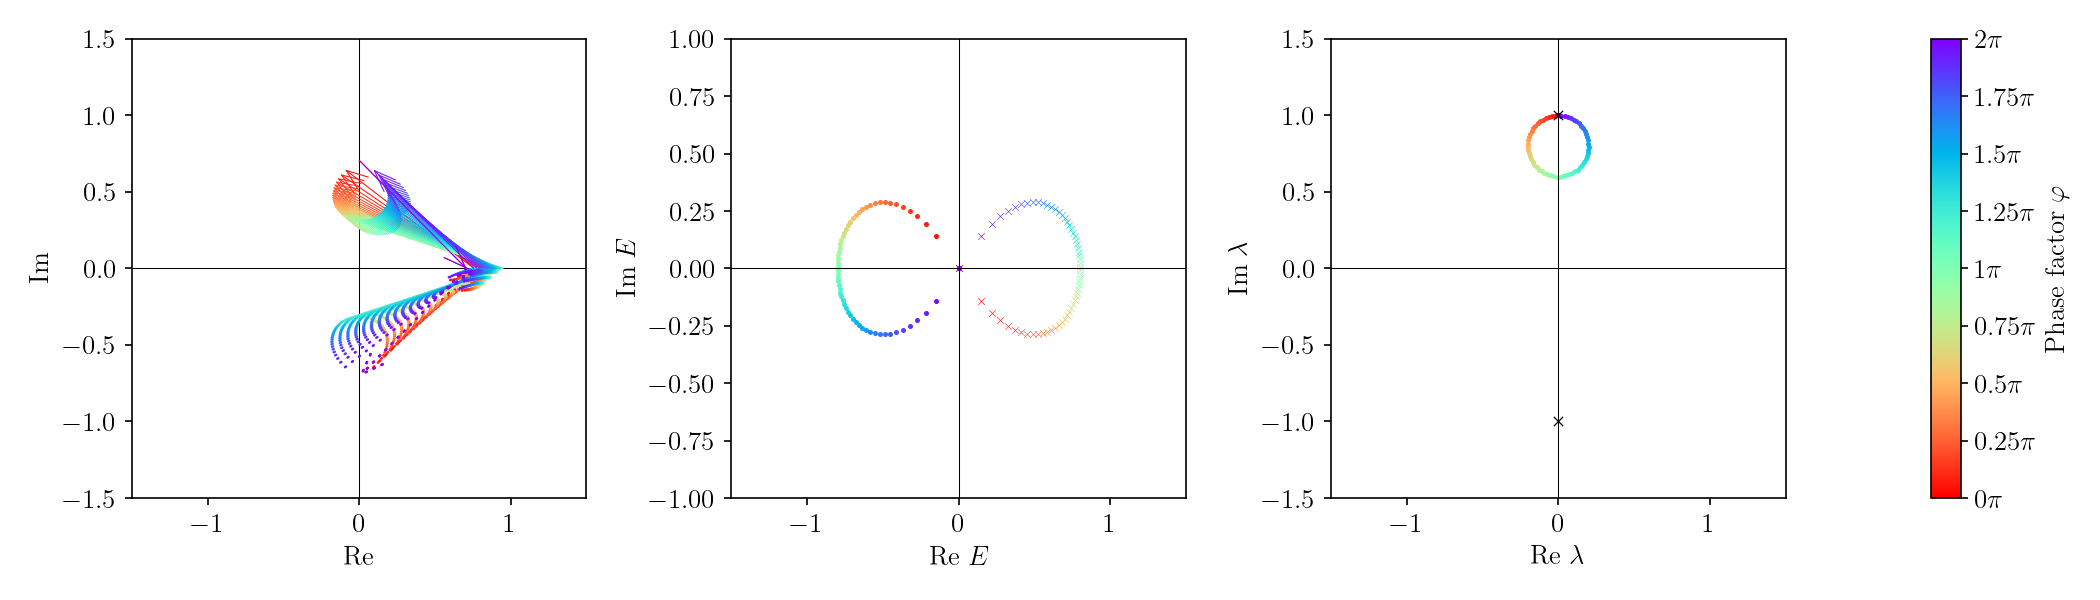

In [137]:
### encircling Re(\lamda), Im(\lambda)
import matplotlib.ticker as tck
import matplotlib.cm as cmx
import matplotlib.colors as colors

fig, ax = plt.subplots(figsize=(14,4), sharey=True, dpi=150, facecolor='w', edgecolor='k')
gs = gridspec.GridSpec(ncols=4, nrows=1, width_ratios=[15,15,15,1], figure=fig) 
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[2])
ax3 = plt.subplot(gs[3])

nn = 60
nmin = 0
nmax = 2 #2*np.pi
shift = 1/2 #np.pi/2

mid = (0+0.8j) 
z = 0.2

matx_dummy = np.array([[-1, 0],[0, 1]], dtype=complex)

cm1 = plt.get_cmap('rainbow_r')
cn1  = colors.Normalize(vmin=nmin, vmax=nmax)
scm1 = cmx.ScalarMappable(norm=cn1, cmap=cm1)
last_vh = np.array([0,0],dtype=complex)

for numb in np.linspace(nmin, nmax, nn):
    vh, vv = pert_mat2(matx_dummy, (numb+shift)*np.pi, z=z, mid=mid)
    
    vh1, vh2 = vh
    va, vb = vv #check(vv)
    
    #print(vh1,vh2, va, vb)
    pr = dict(arrowstyle="->,head_width=0.3,head_length=0.8", shrinkA=0, shrinkB=0, color=scm1.to_rgba(np.real(numb)), linewidth=0.5) 
    
    vv = va #center2(va)
    
    ax0.annotate("", xytext=(np.real(vv[0]), np.imag(vv[0])), xy=(np.real(vv[1]), np.imag(vv[1])), arrowprops=pr)
    
    vv = vb#*1j #center2(vb)
    
    pr.update(dict(linestyle=(0, (0.5,3)), linewidth=1.2))
    ax0.annotate("", xytext=(np.real(vv[0]), np.imag(vv[0])), xy=(np.real(vv[1]), np.imag(vv[1])), arrowprops=pr)
    
    # eigenvalues:
    ax1.scatter(np.real(vh1), np.imag(vh1), color=scm1.to_rgba(np.real(numb)), s=2)
    ax1.scatter(np.real(vh2), np.imag(vh2), color=scm1.to_rgba(np.real(numb)), s=10, linewidth=0.3, marker='x')
    
    # lambda
    ax2.scatter(np.real(mid) + z * np.cos((numb+shift)*np.pi), np.imag(mid) + z * np.sin((numb+shift)*np.pi),color=scm1.to_rgba(np.real(numb)), s=2)
    
ax0.plot([0,0], [-10,10], color='black', linewidth=0.5)
ax0.plot([-10,10], [0,0], color='black', linewidth=0.5)
ax1.plot([0,0], [-10,10], color='black', linewidth=0.5)
ax1.plot([-10,10], [0,0], color='black', linewidth=0.5)
ax2.plot([0,0], [-10,10], color='black', linewidth=0.5)
ax2.plot([-10,10], [0,0], color='black', linewidth=0.5)

ax0.set_xlim(-1.5,1.5)
ax0.set_ylim(-1.5,1.5)

ax1.set_xlim(-1.5, 1.5)
ax1.set_ylim(-1, 1)

ax2.set_xlim(-1.5,1.5)
ax2.set_ylim(-1.5,1.5)
ax2.scatter([0,0], [-1,1], marker='x', s=20, color='k', linewidth=0.6)

ax0.set_ylabel("$\\textrm{Im}$")
ax0.set_xlabel("$\\textrm{Re}$")
ax1.set_ylabel("$\\textrm{Im}\\ E$")
ax1.set_xlabel("$\\textrm{Re}\\ E$")
ax2.set_ylabel("$\\textrm{Im}\\ \\lambda$")
ax2.set_xlabel("$\\textrm{Re}\\ \\lambda$")

plt.colorbar(cm.ScalarMappable(norm=cn1, cmap=cm1), ax=ax0, cax=ax3, label="$\\textrm{Phase\\ factor}\\ \\varphi$", format='$%g \pi$')

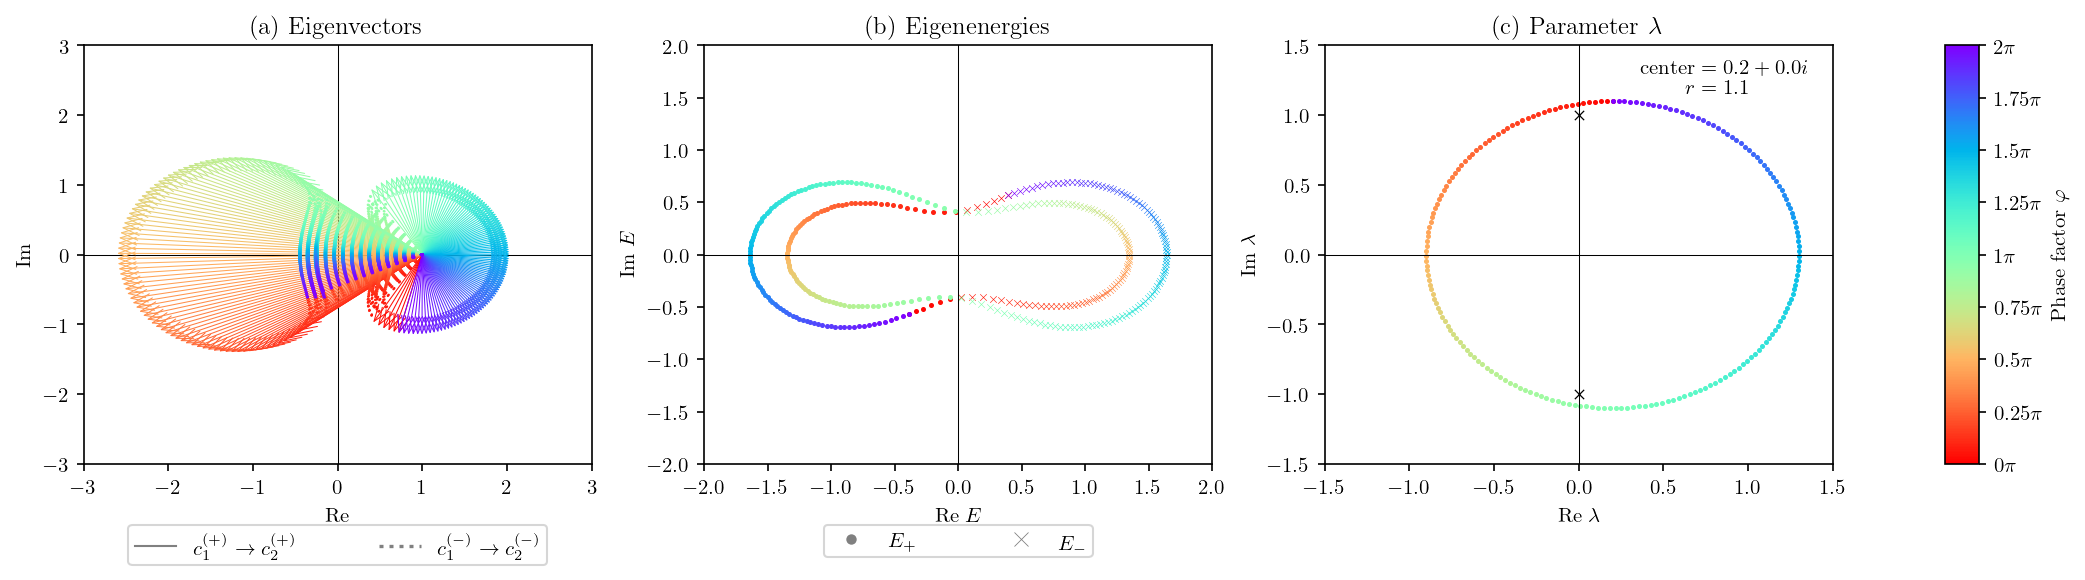

In [398]:
%matplotlib inline
### encircling Re(\lamda), Im(\lambda)
import matplotlib.ticker as tck
import matplotlib.cm as cmx
import matplotlib.colors as colors

fig, ax = plt.subplots(figsize=(14,4), sharey=True, dpi=150, facecolor='w', edgecolor='k')
gs = gridspec.GridSpec(ncols=4, nrows=1, width_ratios=[15,15,15,1], figure=fig) 
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[2])
ax3 = plt.subplot(gs[3])

nn = 200
nmin = 0
nmax = 2 #2*np.pi
shift = 1/2 #np.pi/2

mid = (0.2+0.0j) 
z = 1.1

matx_dummy = np.array([[-1, 0],[0, 1]], dtype=complex)

cm1 = plt.get_cmap('rainbow_r')
cn1  = colors.Normalize(vmin=nmin, vmax=nmax)
scm1 = cmx.ScalarMappable(norm=cn1, cmap=cm1)
last_vh = np.array([0,0],dtype=complex)

for numb in np.linspace(nmin, nmax, nn):
    vh, vv = pert_mat2(matx_dummy, (numb+shift)*np.pi, z=z, mid=mid)
    
    vh1, vh2 = vh
    
    lam = np.real(mid) + np.abs(z) * np.cos((numb+shift)*np.pi) + 1j * (np.imag(mid) + np.abs(z) * np.sin((numb+shift)*np.pi))
    #print("LAM:",lam)
    sq = np.sqrt(lam**2 +1)
    va = np.array([1, lam / (-1 + sq)])
    #va = va / np.sum(np.abs(va)**2)
    vb = np.array([1, lam / (-1 - sq)])
    #vb = vb / np.sum(np.abs(vb)**2)
    #va, vb = vv #check(vv)
    
    #print(vh1,vh2, va, vb)
    pr = dict(arrowstyle="->,head_width=0.3,head_length=0.8", shrinkA=0, shrinkB=0, color=scm1.to_rgba(np.real(numb)), linewidth=0.5) 
    
    vv = va #center2(va)
    
    ax0.annotate("", xytext=(np.real(vv[0]), np.imag(vv[0])), xy=(np.real(vv[1]), np.imag(vv[1])), arrowprops=pr)
    
    vv = vb#*1j #center2(vb)
    
    pr.update(dict(linestyle=(0, (0.5,3)), linewidth=1.2))
    ax0.annotate("", xytext=(np.real(vv[0]), np.imag(vv[0])), xy=(np.real(vv[1]), np.imag(vv[1])), arrowprops=pr)
    
    # eigenvalues:
    ax1.scatter(np.real(vh1), np.imag(vh1), color=scm1.to_rgba(np.real(numb)), s=2)
    ax1.scatter(np.real(vh2), np.imag(vh2), color=scm1.to_rgba(np.real(numb)), s=10, linewidth=0.3, marker='x')
    
    # lambda
    ax2.scatter(np.real(mid) + z * np.cos((numb+shift)*np.pi), np.imag(mid) + z * np.sin((numb+shift)*np.pi),color=scm1.to_rgba(np.real(numb)), s=2)
    
ax0.plot([0,0], [-20,20], color='black', linewidth=0.5)
ax0.plot([-20,20], [0,0], color='black', linewidth=0.5)
ax1.plot([0,0], [-10,10], color='black', linewidth=0.5)
ax1.plot([-10,10], [0,0], color='black', linewidth=0.5)
ax2.plot([0,0], [-10,10], color='black', linewidth=0.5)
ax2.plot([-10,10], [0,0], color='black', linewidth=0.5)

d0=3
ax0.set_xlim(-d0,d0)
#ax0.set_ylim(-2.6,0.2)
ax0.set_ylim(-d0,d0)

d1 = 2
ax1.set_xlim(-d1, d1)
ax1.set_ylim(-d1, d1)

ax2.set_xlim(-1.5,1.5)
ax2.set_ylim(-1.5,1.5)
ax2.scatter([0,0], [-1,1], marker='x', s=20, color='k', linewidth=0.6)

ax0.set_ylabel("$\\textrm{Im}$")
ax0.set_xlabel("$\\textrm{Re}$")
ax1.set_ylabel("$\\textrm{Im}\\ E$")
ax1.set_xlabel("$\\textrm{Re}\\ E$")
ax2.set_ylabel("$\\textrm{Im}\\ \\lambda$")
ax2.set_xlabel("$\\textrm{Re}\\ \\lambda$")

ax0.set_title(r"$\textrm{(a) Eigenvectors}$")
ax1.set_title(r"$\textrm{(b) Eigenenergies}$")
ax2.set_title(r"$\textrm{(c) Parameter } \lambda$")

from matplotlib.lines import Line2D
leg_el1 = [Line2D([0],[0], color='w', markerfacecolor='gray', marker='o', markersize=6, label='$E_+$'), 
          Line2D([0],[0], color='w', markeredgecolor='gray', marker='x', markersize=7, label='$E_-$', lw=0.3 ,markeredgewidth=0.4)]
ax1.legend(handles=leg_el1, loc='upper center',ncol=2, bbox_to_anchor=(0.5, -0.122),borderpad=0.3, columnspacing=4)

leg_el0 = [Line2D([0],[0], color='gray', label='$c_1^{(+)} \\rightarrow c_2^{(+)}$', lw=1),
           Line2D([0],[0], color='gray', label='$c_1^{(-)} \\rightarrow c_2^{(-)}$', linestyle=(0, (1.2,1.8)), lw=1.6), 
          ]
ax0.legend(handles=leg_el0, loc='upper center', ncol=2, bbox_to_anchor=(0.5, -0.122), borderpad=0.3, columnspacing=4)

leg_el2 = [Line2D([0],[0], color='gray', label='$c_1^{(+)} \\rightarrow c_2^{(+)}$', lw=1),
           Line2D([0],[0], color='gray', label='$c_1^{(-)} \\rightarrow c_2^{(-)}$', linestyle=(0, (1.2,1.8)), lw=1.6), 
          ]
#ax0.legend(handles=leg_el2, loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.2), borderpad=0.3, columnspacing=5)

ax2.annotate(r"\parbox{40mm}{\begin{align*}\textrm{center}"+r"&={:.1f}+".format(np.real(mid))+r"{:.1f}i\\[-2mm]".format(np.imag(mid))+r"r &= {:.1f}".format(z)+r"\end{align*}}",
             xy=(0.62,0.92), xycoords='axes fraction')

plt.colorbar(cm.ScalarMappable(norm=cn1, cmap=cm1), ax=ax0, cax=ax3, label="$\\textrm{Phase\\ factor}\\ \\varphi$", format='$%g \pi$')
plt.tight_layout()

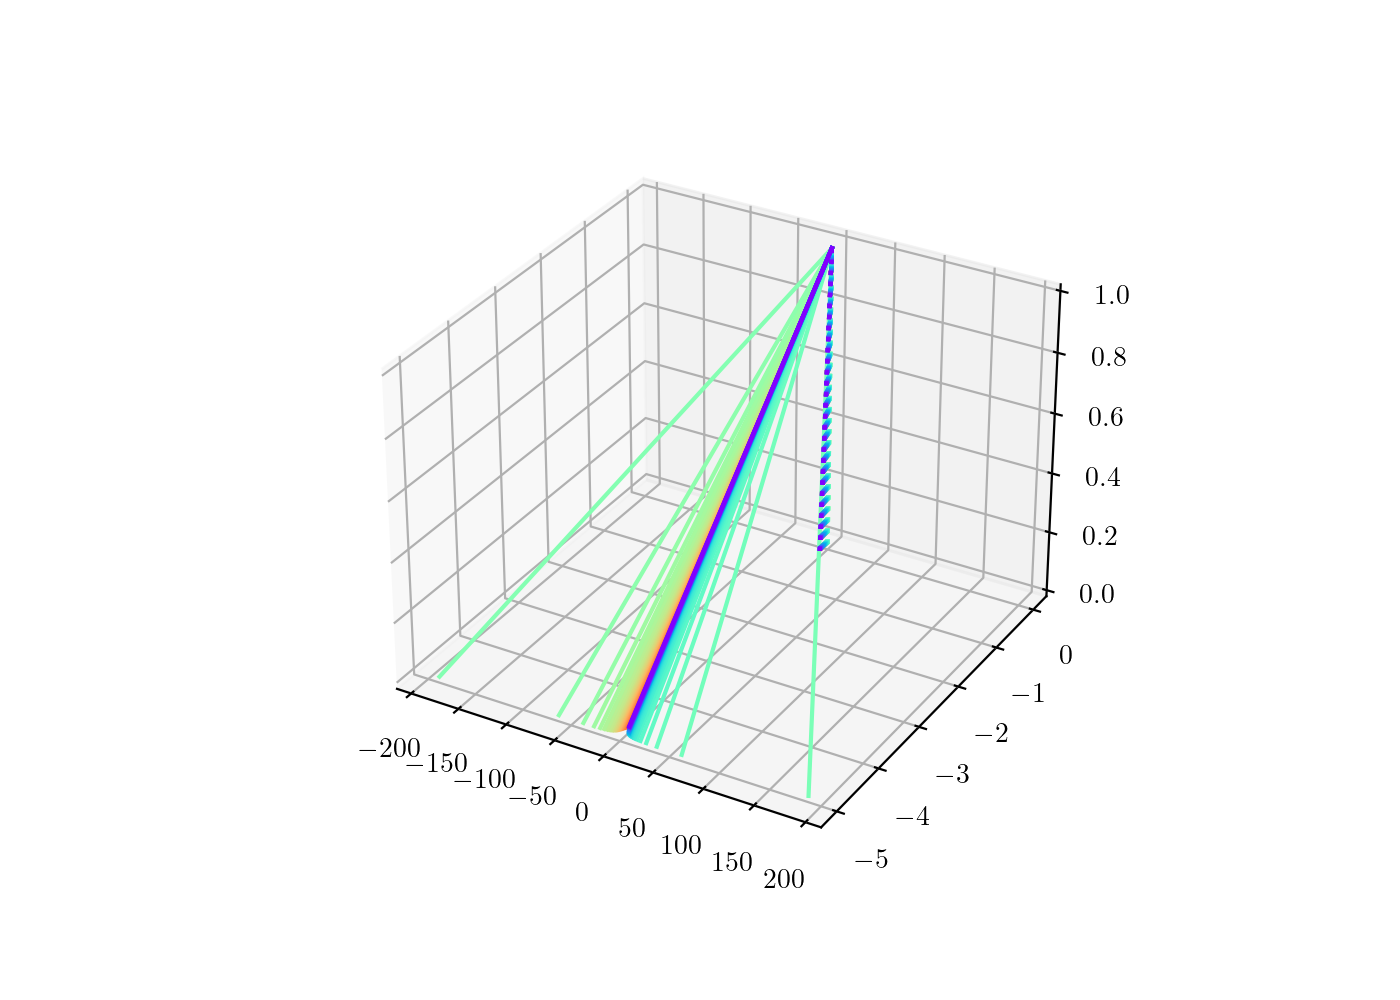

In [299]:
%matplotlib widget

import matplotlib.ticker as tck
import matplotlib.cm as cmx
import matplotlib.colors as colors
import numpy as np
import matplotlib.pyplot as plt

fig3D = plt.figure(figsize=(7,5), dpi=200)
ax3D = plt.subplot(111, projection='3d' )

cm3d = plt.get_cmap('rainbow_r')
cn3d  = colors.Normalize(vmin=nmin, vmax=nmax)
scm3d = cmx.ScalarMappable(norm=cn3d, cmap=cm3d)

####
nn = 60
nmin = 0
nmax = 2 #2*np.pi
shift = 1/2 #np.pi/2

mid = (0+0.2j) 
z = 0.2

for numb in np.linspace(nmin, nmax, nn):    
    lam = np.real(mid) + np.abs(z) * np.cos((numb+shift)*np.pi) + 1j * (np.imag(mid) + np.abs(z) * np.sin((numb+shift)*np.pi))
    sq = np.sqrt(lam**2 +1)
    va = np.array([1, lam / (-1 + sq)])
    vb = np.array([1, lam / (-1 - sq)])
    
    ax3D.plot([np.real(va[1]), 0], [np.imag(va[1]), 0], [0, np.real(va[0])], color=scm3d.to_rgba(numb))
    ax3D.plot([np.real(vb[1]), 0], [np.imag(vb[1]), 0], [0, np.real(vb[0])], color=scm3d.to_rgba(numb), linestyle='dotted')
    
#plt.colorbar(cm.ScalarMappable(norm=cn1, cmap=cm1), ax=ax0, cax=ax3, label="$\\textrm{Phase\\ factor}\\ \\varphi$", format='$%g \pi$')

In [141]:
h = np.array([1, -1j], dtype=complex)
h

array([ 1.+0.j, -0.-1.j])

In [143]:
np.sum(h* np.conjugate(h))

(2+0j)

In [131]:
np.linalg.eig(np.array([[-1, 1.2j],[1.2j, 1]], dtype=complex))

(array([1.11022302e-16+0.66332496j, 1.89941213e-17-0.66332496j]),
 array([[ 0.39086798+0.58925565j, -0.39086798+0.58925565j],
        [ 0.70710678+0.j        ,  0.70710678+0.j        ]]))

In [497]:
def check(v):
    out=list()
    for vv in v:
        print(vv)
        if np.imag(np.subtract(*vv)) > 0:
            out.append(vv[::-1])
        else:
            out.append(vv)
    return np.array(out, dtype=complex)

In [44]:
def matice(lamb):
    m = np.array([[-1, lamb],[lamb, 1]], dtype=complex)
    return np.linalg.eig(m)

In [510]:
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
fig3D = plt.figure()
ax3D = fig.add_subplot(111, projection='3d')


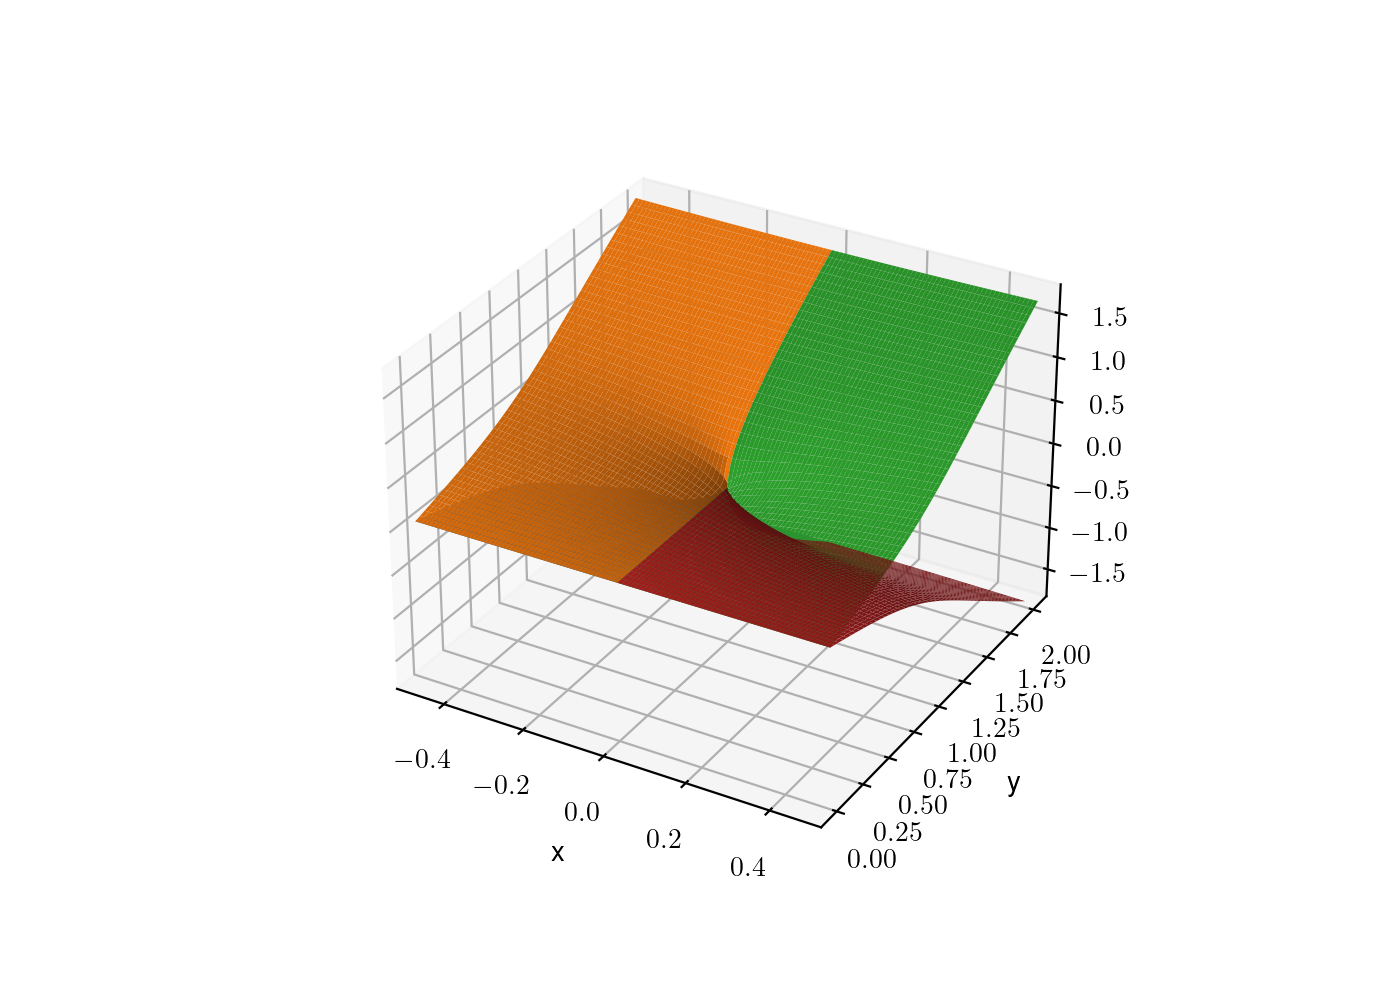

In [399]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt

fig3D = plt.figure(figsize=(7,5), dpi=200)
ax3D = plt.subplot(111, projection='3d' )

plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True

zero = 1e-20

xp = np.linspace(zero, 0.5, 1000)
xm = np.linspace(-0.5, -zero, 1000)
y = np.linspace(0, 2, 1000)

plus = np.meshgrid(xp, y)
minus = np.meshgrid(xm, y)

cm3d = plt.get_cmap('rainbow_r')
cn3d  = colors.Normalize(vmin=nmin, vmax=nmax)
scm3d = cmx.ScalarMappable(norm=cn3d, cmap=cm3d)

for x,y in (minus, plus):
    zplus = np.imag(np.sqrt((x + y*1j)**2 +1 ))
    zminus = np.imag(-np.sqrt((x + y*1j)**2 +1 ))

    ax3D.plot_surface(x, y, zplus)
    ax3D.plot_surface(x, y, zminus)

ax3D.set_xlabel('x')
ax3D.set_ylabel('y')

ax3D.set_xlim(-0.5,0.5)

plt.show()

# Mayavi !!!

## Riemann

In [400]:
from mayavi import mlab
import numpy as np

In [401]:
%gui qt

In [666]:
mlab.clf()
x, y = np.mgrid[-10:10:100j, -10:10:100j]
r = np.sqrt(x**2 + y**2)
z = np.sin(r)/r
mlab.surf(z, warp_scale='auto')

In [26]:
%gui qt
mlab.clf()

zero = 1e-40

xp = np.linspace(zero, 1, 1000)
xm = np.linspace(-1, -zero, 1000)
y = np.linspace(-2, 2, 1000)

plus = np.meshgrid(xp, y)
minus = np.meshgrid(xm, y)

cm3d = plt.get_cmap('rainbow_r')
cn3d  = colors.Normalize(vmin=nmin, vmax=nmax)
scm3d = cmx.ScalarMappable(norm=cn3d, cmap=cm3d)

x, y = minus
zp = np.sqrt((x + y*1j)**2 +1 )
zm = -np.sqrt((x + y*1j)**2 +1 )
srf = mlab.surf(np.imag(zp), extent=[-5,5,-5,0,-2,2])
srf = mlab.surf(np.imag(zm), extent=[-5,5,-5,0,-2,2])


x, y = plus
zp = np.sqrt((x + y*1j)**2 +1 )
zm = -np.sqrt((x + y*1j)**2 +1 )
srf = mlab.surf(np.imag(zp), extent=[-5,5,0,5,-2,2])
srf = mlab.surf(np.imag(zm), extent=[-5,5,0,5,-2,2])

 
sax = mlab.axes(srf, z_axis_visibility=False, extent=[-5,5,-10,10,-1,1], ranges=[-1,1,-2,2,-1,1])

In [404]:
%gui qt
### MAIN - working !!!!!!!!!!!!!!!!!!!!

mlab.clf()
mlab.figure(bgcolor=(1, 1, 1))

zero = 1e-40

xp = np.linspace(zero, 2, 1000)
xm = np.linspace(-2, -zero, 1000)
y = np.linspace(-2, 2, 1000)

plus = np.meshgrid(xp, y)
minus = np.meshgrid(xm, y)

x, y = minus
zp = np.sqrt((x + y*1j)**2 +1 )
zm = -np.sqrt((x + y*1j)**2 +1 )
srf1 = mlab.mesh(x,y,-np.imag(zp), scalars=np.real(zp))
srf2 = mlab.mesh(x,y,-np.imag(zm), scalars=np.real(zm), opacity=0.45)

x, y = plus
zp = np.sqrt((x + y*1j)**2 +1 )
zm = -np.sqrt((x + y*1j)**2 +1 )
srf3 = mlab.mesh(x,y,-np.imag(zp), scalars=np.real(zp))
srf4 = mlab.mesh(x,y,-np.imag(zm), scalars=np.real(zm), opacity=0.45)

for i, srf in enumerate([srf1, srf2, srf3, srf4]):
    srf = split_cmap(srf, i=i%2)
    
xi = np.linspace(-2, 2, 1000)
yi = np.linspace(-2, 2, 1000)
xi, yi = np.meshgrid(xi, yi)
ziplus = np.sqrt((xi + yi*1j)**2 +1 )
ziminus = -np.sqrt((xi + yi*1j)**2 +1 )
srfi = mlab.mesh(xi, yi, np.imag(ziplus), scalars=np.real(ziplus))
srfi.actor.actor.visibility = False

mcb = mlab.colorbar(srfi, orientation='vertical', nb_labels=5)
srfi.module_manager.scalar_lut_manager.data_range = np.array([np.min(np.real(ziminus)), np.max(np.real(ziplus))])

#srf.module_manager.scalar_lut_manager.reverse_lut = True  
sax = mlab.axes(srfi)#, extent=[-1,1,-2,2,-2,2], ranges=[-1,1,-2,2,-2,2])

scene = mlab.gcf()
scene.scene.camera.position = [-6.557786257167472, -12.166958293475863, 6.265801619455065]
scene.scene.camera.focal_point = [-0.6005004048987784, 0.1650163128315011, -0.727957090511314]
scene.scene.camera.view_angle = 30.0
scene.scene.camera.view_up = [0.17398809184187736, 0.42085344587700746, 0.8902867633468844]
scene.scene.camera.clipping_range = [8.561462331426489, 23.473639184024062]
scene.scene.camera.compute_view_plane_normal()

sax.axes.property.color = (0.0, 0.0, 0.0)

sax.axes.x_label = "Re lambda"
sax.axes.y_label = "Im lambda"
sax.axes.z_label = "Im E"

mcb.label_text_property.color = (0.0, 0.0, 0.0)
sax.label_text_property.color = (0.0, 0.0, 0.0)
sax.title_text_property.color = (0.0, 0.0, 0.0)
sax.title_text_property.italic = False
sax.axes.number_of_labels = 5
sax.axes.label_format = '%-#6.2g'
sax.axes.font_factor = 1.2
mcb.label_text_property.italic = False
sax.label_text_property.bold = False

scene.scene.render()

In [402]:
def split_cmap(obj, i=0):
    lut = obj.module_manager.scalar_lut_manager.lut.table.to_array()
    lut2 = np.kron(lut[128*i:128*(i+1)], np.array([[1,],[1,]]))
    obj.module_manager.scalar_lut_manager.lut.table = lut2[::-1]
    
    return obj

## Vectors

In [ ]:
%gui qt

mlab.clf()
mlab.figure(bgcolor=(1, 1, 1))

nn = 60
nmin = 0
nmax = 2 #2*np.pi
shift = 1/2 #np.pi/2

mid = (0+0.9j) 
z = 0.2

xx = list()
yy = list()
zz = list()

rng = np.linspace(nmin, nmax, nn)
for numb in rng:    
    lam = np.real(mid) + np.abs(z) * np.cos((numb+shift)*np.pi) + 1j * (np.imag(mid) + np.abs(z) * np.sin((numb+shift)*np.pi))
    sq = np.sqrt(lam**2 +1)
    va = np.array([1, lam / (-1 + sq)])
    vb = np.array([1, lam / (-1 - sq)])
    
    xx.append([np.real(va[1]), 0])
    yy.append([np.imag(va[1]), 0])
    zz.append([0, np.real(va[0])])
    
    #p3d = mlab.plot3d([np.real(va[1]), 0], [np.imag(va[1]), 0], [0, np.real(va[0])], [numb]*2, colormap='gist_rainbow')
    #mlab.plot3d([np.real(vb[1]), 0], [np.imag(vb[1]), 0], [0, np.real(vb[0])], color=scm3d.to_rgba(numb), linestyle='dotted')
    
mlab.plot3d(x,y,z, colormap='gist_rainbow')

lut = np.zeros((len(rng), 4))
p3d.module_manager.scalar_lut_manager.lut.number_of_colors = len(rng)
p3d.module_manager.scalar_lut_manager.lut.table = lut

mcb = mlab.colorbar(vects1, orientation='vertical', nb_labels=5)
srfi.module_manager.scalar_lut_manager.data_range = np.array([np.min(np.real(ziminus)), np.max(np.real(ziplus))])

#srf.module_manager.scalar_lut_manager.reverse_lut = True  
sax = mlab.axes(srfi)#, extent=[-1,1,-2,2,-2,2], ranges=[-1,1,-2,2,-2,2])

scene = mlab.gcf()
scene.scene.camera.position = [-6.557786257167472, -12.166958293475863, 6.265801619455065]
scene.scene.camera.focal_point = [-0.6005004048987784, 0.1650163128315011, -0.727957090511314]
scene.scene.camera.view_angle = 30.0
scene.scene.camera.view_up = [0.17398809184187736, 0.42085344587700746, 0.8902867633468844]
scene.scene.camera.clipping_range = [8.561462331426489, 23.473639184024062]
scene.scene.camera.compute_view_plane_normal()

sax.axes.property.color = (0.0, 0.0, 0.0)

sax.axes.x_label = "Re lambda"
sax.axes.y_label = "Im lambda"
sax.axes.z_label = "Im E"

mcb.label_text_property.color = (0.0, 0.0, 0.0)
sax.label_text_property.color = (0.0, 0.0, 0.0)
sax.title_text_property.color = (0.0, 0.0, 0.0)
sax.title_text_property.italic = False
sax.axes.number_of_labels = 5
sax.axes.label_format = '%-#6.2g'
sax.axes.font_factor = 1.2
mcb.label_text_property.italic = False
sax.label_text_property.bold = False

scene.scene.render()

In [251]:
"""Generates a pretty set of lines."""
n_mer, n_long = 6, 11
dphi = np.pi / 1000.0
phi = np.arange(0.0, 2 * np.pi + 0.5 * dphi, dphi)
mu = phi * n_mer
x = np.cos(mu) * (1 + np.cos(n_long * mu / n_mer) * 0.5)
y = np.sin(mu) * (1 + np.cos(n_long * mu / n_mer) * 0.5)
z = np.sin(n_long * mu / n_mer) * 0.5

mlab.plot3d(x, y, z, np.sin(mu), tube_radius=0.025, colormap='Spectral')

In [ ]:
import numpy as np

# The number of points per line
N = 300

# The scalar parameter for each line
t = np.linspace(-2 * np.pi, 2 * np.pi, N)

from mayavi import mlab
mlab.figure(1, size=(400, 400), bgcolor=(0, 0, 0))
mlab.clf()

# We create a list of positions and connections, each describing a line.
# We will collapse them in one array before plotting.
x = list()
y = list()
z = list()
s = list()
connections = list()

# The index of the current point in the total amount of points
index = 0

# Create each line one after the other in a loop
for i in range(50):
    x.append(np.sin(t))
    y.append(np.cos((2 + .02 * i) * t))
    z.append(np.cos((3 + .02 * i) * t))
    s.append(t)
    # This is the tricky part: in a line, each point is connected
    # to the one following it. We have to express this with the indices
    # of the final set of points once all lines have been combined
    # together, this is why we need to keep track of the total number of
    # points already created (index)
    connections.append(np.vstack(
                       [np.arange(index,   index + N - 1.5),
                        np.arange(index + 1, index + N - .5)]
                            ).T)
    index += N

# Now collapse all positions, scalars and connections in big arrays
x = np.hstack(x)
y = np.hstack(y)
z = np.hstack(z)
s = np.hstack(s)
connections = np.vstack(connections)

# Create the points
src = mlab.pipeline.scalar_scatter(x, y, z, s)

# Connect them
src.mlab_source.dataset.lines = connections
src.update()

# The stripper filter cleans up connected lines
lines = mlab.pipeline.stripper(src)

# Finally, display the set of lines
mlab.pipeline.surface(lines, colormap='Accent', line_width=1, opacity=.4)

# And choose a nice view
mlab.view(33.6, 106, 5.5, [0, 0, .05])
mlab.roll(125)
mlab.show()

KeyboardInterrupt: 